In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
from optic.models.devices import photodiode, basicLaserModel, pm
from optic.models.channels import linearFiberChannel
from optic.dsp.core import phaseNoise, firFilter, pulseShape, signal_power ,delaySignal
from optic.models.amplification import OSA, get_spectrum
from optic.utils import parameters
from optic.plot import plotPSD
from scipy.constants import h, c
from matplotlib import mlab
import scipy.signal as signal
from scipy.signal import hilbert, lfilter, firwin, freqz, windows
from scipy.signal.windows import hamming
from scipy.ndimage import shift
from IPython.display import display, Math
from commpy.utilities import upsample
from tqdm.notebook import tqdm  # Needs installation of jupyter and ipywidgets packages

sys.path.append('..\..\Functions')

from laser_dfb import *
from laser_cw import *
from AuxiliaryFunctions import *

fontSmall = {'family':'serif', 'weight':'normal', 'size':12}
font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

# Parameters and simulation

In [170]:
# simulation parameters
SpS = 64*2    # Samples per Symbol
Rs = 170e6  # Symbol rate (for OOK case Rs = Rb)

Tsymb = 1/Rs       # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs          # Sampling period

# generate pseudo-random bit sequence
bitsTx = np.ones(2**14)

lmbd = 1540e-9       # Central Wavelength [m]
KConst = 0.5         # Coupling Constant (0 to 1)
KPhase = (1/2)*np.pi   # Coupling Phase Delay between arms (rad)

SMFLen = 12          # Single Mode Fiber Length (km)
SMFAtt = 0.22        # Single Mode Fiber Attenuation (dB/km)
SMFGamma = 1.2       # Single Mode Fiber Nonlinear parameter (1/(W*km))
SMFDisp = 16         # Single Mode Fiber Chromatic Dispersion parameter (ps/nm/km)
tau = SMFLen/(c*1e-3)    # Fiber Delay

mFreq = 2e9     # Frequency of the electrical modulating signal (Hz)
mPhase = 0      # Phase of the electrical modulating signal (Radians)
R = 1           # Photodiode Responsivity

tArray = np.arange(0,SpS*len(bitsTx))*Ts

laser_parameters = parameters()
laser_parameters.P = 10 # laser power [dBm] 
laser_parameters.lw = 15e6 # laser linewidth [Hz] 
laser_parameters.RIN_var = 1e-20 # variance of the RIN noise 
laser_parameters.Fs = Fs # sampling rate [samples/s]
laser_parameters.Ns = SpS*bitsTx.size # number of signal samples

OptSig = basicLaserModel(laser_parameters)

print(f'Samples: {SpS*bitsTx.size}')
print(f'Total sample time: {SpS*len(bitsTx)*Ts*1e6} us')
print(f'Sampling period: {Ts*1e12} ps')
print(f'Sampling frequency: {Fs*1e-9} Gsample/s')
print(f'Linewidth: {laser_parameters.lw * 1e-6} MHz')
print(f'Power: {laser_parameters.P} dBm')

print(f'Delay: {tau*1e6} us')
# print(f'Delay: {1e6/(c*1e-3)} us')

Samples: 2097152
Total sample time: 96.37647058823529 us
Sampling period: 45.955882352941174 ps
Sampling frequency: 21.76 Gsample/s
Linewidth: 15.0 MHz
Power: 10 dBm
Delay: 40.02769142377824 us


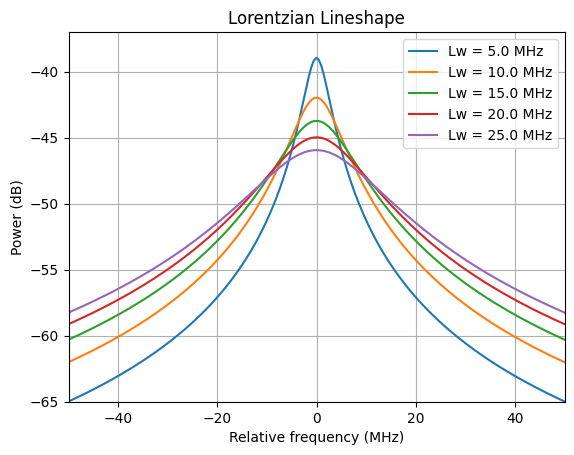

In [171]:
P = 1e3
freqAr = np.linspace(c/1542e-9 , c/1538e-9, 1000000)
f0 = c/1540e-9

delVArray = np.linspace(5e6,25e6,5)

for i in range(len(delVArray)):
    delV = delVArray[i]
    LorentzS = P/(2*np.pi) * delV/((freqAr - f0)**2 + (delV/2)**2)
    plt.plot((freqAr-f0)*1e-6,10*np.log10(LorentzS),label=f'Lw = {delV*1e-6} MHz')

plt.xlim(-50e6*1e-6,50e6*1e-6)
plt.ylim(-95+10*np.log10(P),-67+10*np.log10(P))
plt.title(f'Lorentzian Lineshape')
plt.xlabel(f'Relative frequency (MHz)')
plt.ylabel(f'Power (dB)')
plt.legend()
plt.grid()

BestleftMark: 194670419.58813632 MHz
BestrightMark: 194670433.8884966 MHz


<IPython.core.display.Math object>

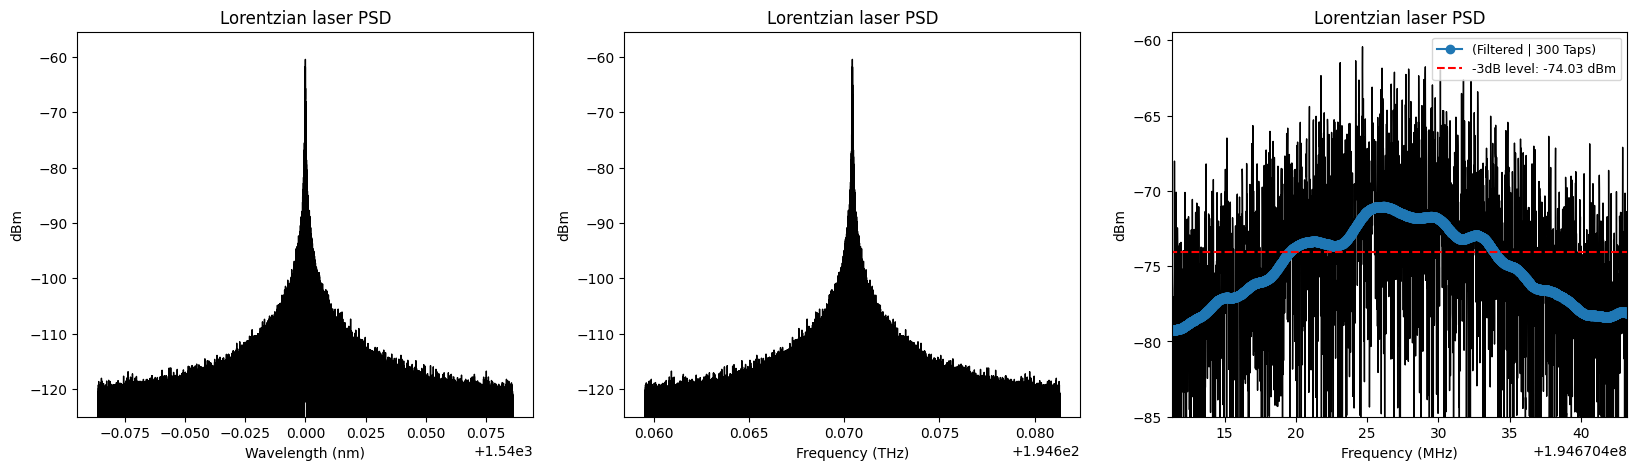

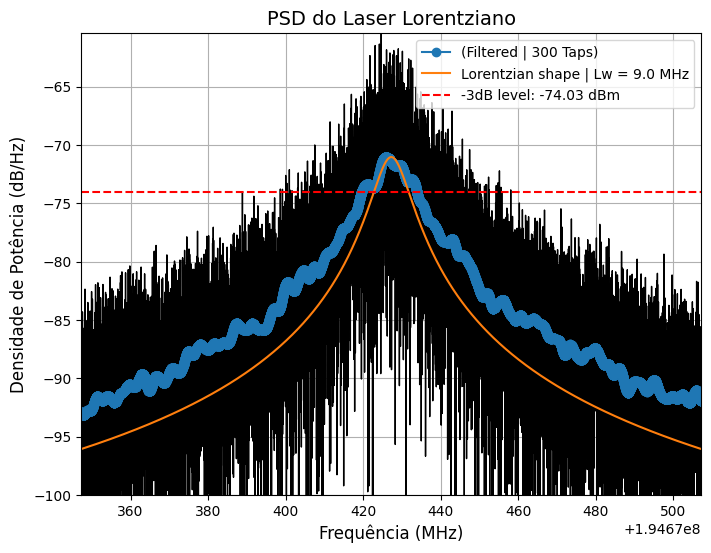

In [62]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

# spectrum2 = len(Epd)*np.abs(np.fft.fft(Epd, norm='forward'))**2/Fs

win = np.hamming(len(OptSig))                       
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 

OptSig_win = OptSig * win  
spectrum = np.abs(np.fft.fft(OptSig_win, norm='forward'))**2 / ENBW 
freq = np.fft.fftfreq(len(OptSig), d=1/Fs)
ax[0].plot(c/(freq + c/lmbd)*1e9 , 10*np.log10(1e3*spectrum),color='black', linewidth=1)
ax[0].set_ylim(-125, np.max(10*np.log10(1e3*spectrum))+5)
ax[0].set_ylabel('dBm')
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_title('Lorentzian laser PSD')

spectrum = np.abs(np.fft.fft(OptSig_win, norm='forward'))**2 / ENBW 
freq = np.fft.fftfreq(len(OptSig), d=1/Fs)
ax[1].plot((freq+c/lmbd)*1e-12, 10*np.log10(1e3*spectrum), color='black',linewidth = 1)
# ax[0].set_xlim(1538,1542)
ax[1].set_ylim(-125,np.max(10*np.log10(1e3*spectrum))+5)
ax[1].set_ylabel('dBm')
ax[1].set_xlabel('Frequency (THz)')
ax[1].set_title('Lorentzian laser PSD')

centerFreq = c/lmbd
cutLims = [c/lmbd - 100e6 , c/lmbd + 100e6]

spectrum = np.concatenate((spectrum[int(len(freq)/2):],spectrum[:int(len(freq)/2)]))
freq = np.concatenate((freq[int(len(freq)/2):],freq[:int(len(freq)/2)]))
initFreq = int((cutLims[0]-freq[0]-centerFreq)/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0]-centerFreq)/(freq[-1]-freq[0])*len(freq))

freq = (freq+c/lmbd)[initFreq:endFreq]
spectrum =  10*np.log10(1e3*spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 300
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

ax[2].plot(freq*1e-6, spectrum, color='black',linewidth = 1)
ax[2].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
ax[2].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
ax[2].set_xlim(c*1e-6/lmbd - 16 , c*1e-6/lmbd + 16)
ax[2].set_ylim(-85,np.max(spectrum)+1)
ax[2].set_ylabel('dBm')
ax[2].set_xlabel('Frequency (MHz)')
ax[2].set_title('Lorentzian laser PSD')
ax[2].legend(fontsize=9)

BestrightMark = 0
BestleftMark = 0

freq = freq[Ntaps:-Ntaps] 

for i in range(len(FilteredSpec)-1):
    if FilteredSpec[i+1] > np.max(FilteredSpec)-3 and FilteredSpec[i] <= np.max(FilteredSpec)-3:
        # print(f'leftMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(leftMark-centerFreq) <= np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] <= np.max(FilteredSpec)-3 and FilteredSpec[i] > np.max(FilteredSpec)-3:
        # print(f'rightMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(rightMark-centerFreq) <= np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
display(Math('Measured~Linewidth = %5.6f~MHz' %(delF)))

# Comparison with a lorentzian shape ---------------------------------------------------

f0 = c/1540e-9
delV = 9e6
LorentzS = 10*np.log10(1/(2*np.pi) * delV/((freq - f0)**2 + (delV/2)**2))
LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))

plt.figure(figsize=(8,6))
plt.plot(freq*1e-6, spectrum[Ntaps:-Ntaps], color='black',linewidth = 1)
plt.plot(freq*1e-6,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
plt.plot(freq*1e-6,LorentzS,label=f'Lorentzian shape | Lw = {np.round(delV*1e-6,2)} MHz')
plt.hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
plt.xlim(c*1e-6/lmbd - 80 , c*1e-6/lmbd + 80)
plt.ylim(-100,np.max(spectrum)+0)
plt.ylabel('Densidade de Potência (dB/Hz)',fontsize=12)
plt.xlabel('Frequência (MHz)',fontsize=12)
plt.title('PSD do Laser Lorentziano',fontsize=14)
plt.grid()
plt.legend(fontsize=10)

# Optical modulator

Modulator used: https://www.eospace.com/small-form-factor-125-gb/s-modulator

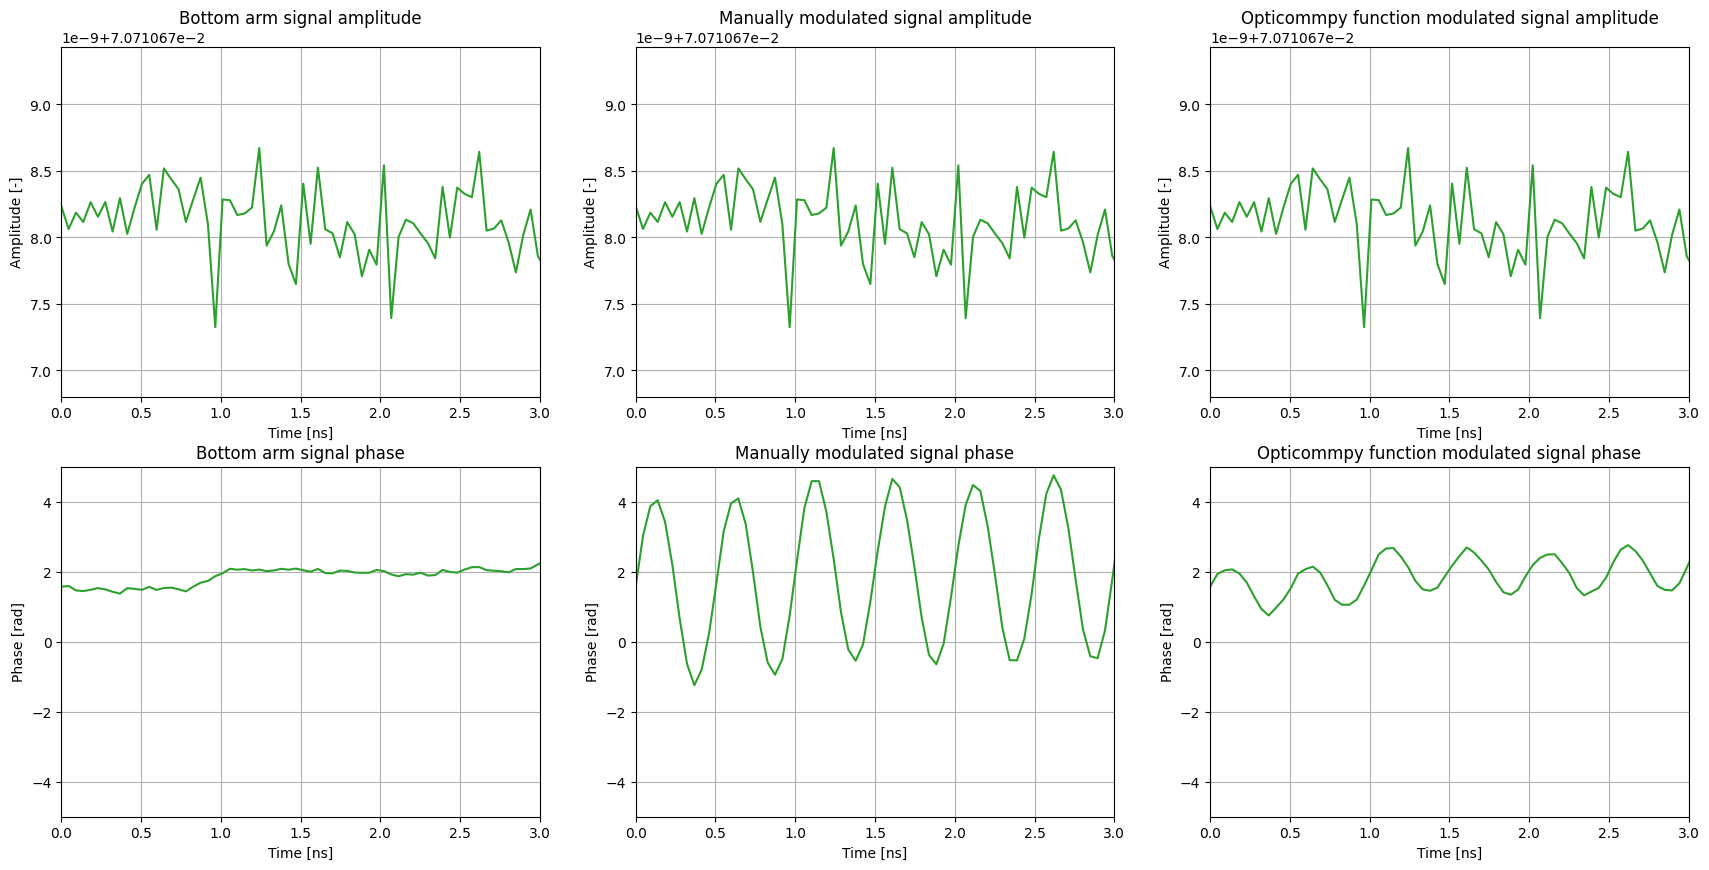

In [172]:
bIdx = 2.63

carrier = OptSig*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
EBottom = carrier*np.exp(1j*bIdx*np.sin(2*np.pi*mFreq*tArray+mPhase)) # Bottom arm Optical signal modulated

elecSig = np.sin(2*np.pi*mFreq*tArray+mPhase)
pmModSignal = pm(carrier,elecSig,5)

fig, ax = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(21)

ax[0][0].plot(tArray*1e9,np.abs(carrier),color='C2')
ax[0][0].set_xlim(0,3)
ax[0][0].set_title(f'Bottom arm signal amplitude')
ax[0][0].set_xlabel('Time [ns]')
ax[0][0].set_ylabel('Amplitude [-]')
ax[0][0].grid()

ax[0][1].plot(tArray*1e9,np.abs(EBottom),color='C2')
ax[0][1].set_xlim(0,3)
ax[0][1].set_title(f'Manually modulated signal amplitude')
ax[0][1].set_xlabel('Time [ns]')
ax[0][1].set_ylabel('Amplitude [-]')
ax[0][1].grid()

ax[0][2].plot(tArray*1e9,np.abs(pmModSignal),color='C2')
ax[0][2].set_xlim(0,3)
ax[0][2].set_title(f'Opticommpy function modulated signal amplitude')
ax[0][2].set_xlabel('Time [ns]')
ax[0][2].set_ylabel('Amplitude [-]')
ax[0][2].grid()

ax[1][0].plot(tArray*1e9,np.unwrap(np.angle(carrier)),color='C2')
ax[1][0].set_xlim(0,3)
ax[1][0].set_ylim(-5,5)
ax[1][0].set_title(f'Bottom arm signal phase')
ax[1][0].set_xlabel('Time [ns]')
ax[1][0].set_ylabel('Phase [rad]')
ax[1][0].grid()

ax[1][1].plot(tArray*1e9,np.unwrap(np.angle(EBottom)),color='C2')
ax[1][1].set_xlim(0,3)
ax[1][1].set_ylim(-5,5)
ax[1][1].set_title(f'Manually modulated signal phase')
ax[1][1].set_xlabel('Time [ns]')
ax[1][1].set_ylabel('Phase [rad]')
ax[1][1].grid()

ax[1][2].plot(tArray*1e9,np.unwrap(np.angle(pmModSignal)),color='C2')
ax[1][2].set_xlim(0,3)
ax[1][2].set_ylim(-5,5)
ax[1][2].set_title(f'Opticommpy function modulated signal phase')
ax[1][2].set_xlabel('Time [ns]')
ax[1][2].set_ylabel('Phase [rad]')
ax[1][2].grid()

# Self-Heterodyne Circuit Operations

Delay: 40.02769142377824 us
Attenuation value: 2.64 dB
Array length: 1226150


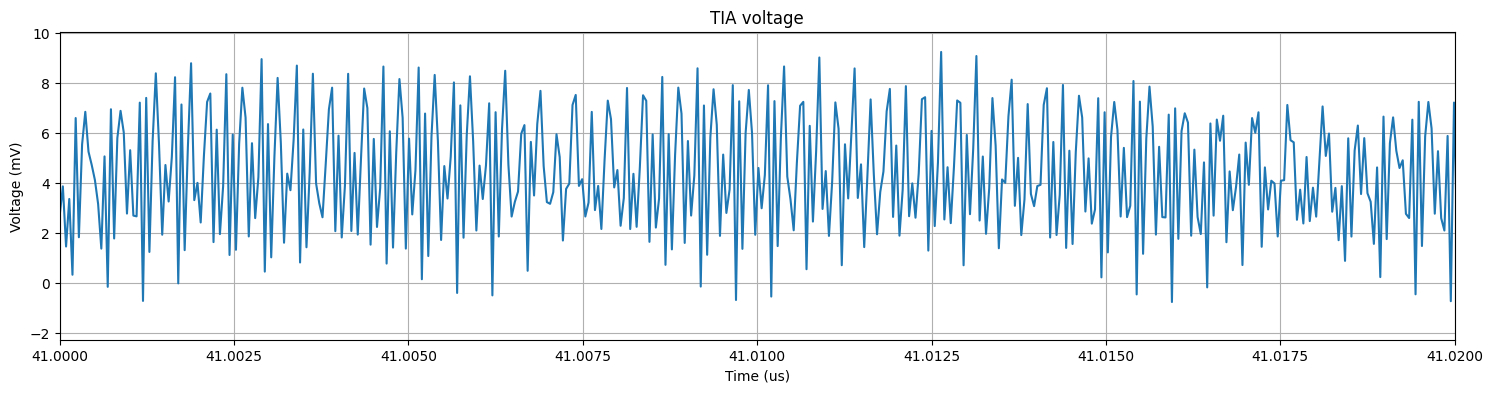

In [173]:
LinearFiber_parameters = parameters()
LinearFiber_parameters.L = SMFLen           # [km] total fiber length
LinearFiber_parameters.alpha = SMFAtt       # [dB/km] fiber attenuation parameter 
LinearFiber_parameters.D = SMFDisp          # [ps/nm/km] chromatic dispersion parameter
LinearFiber_parameters.Fc = c/lmbd          # [Hz] carrier frequency
LinearFiber_parameters.Fs = Fs              # [Hz] sampling frequency 

bIdx = 2          # Modulation index of the electrical modulating signal
vPi = 5               # Modulator vPi [Volts]

TIACutFreq = 10e9  # TIA Filter cuttoff frequency in Hz   
TIAorder = 1  # TIA Filter order      

DemodCutFreq = 0.1e9  # Demodulation Filter cuttoff frequency in Hz     
Demodorder = 3  # Demodulation Filter order

tau = SMFLen/(c*1e-3)    # Fiber Delay
shiftValue = int(len(tArray)*tau/tArray[-1])
print(f'Delay: {tau*1e6} us')
print(f'Attenuation value: {SMFAtt*SMFLen} dB')

EUpper = linearFiberChannel(OptSig*np.sqrt(KConst),LinearFiber_parameters) # Upper arm Optical signal post fiber 
EUpper = shift(EUpper,shiftValue,cval=EUpper[0]) # Applying delay
EUpper = EUpper[shiftValue:]
print(f'Array length: {len(EUpper)}')

carrier = OptSig*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
elecSig = vPi*bIdx*np.sin(2*np.pi*mFreq*tArray+mPhase) # Electrical signal for pm modulation
EBottom = pm(carrier,elecSig,vPi)  # PM modulation
EBottom = EBottom[shiftValue:]

timeArray = tArray[shiftValue:]

Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode


# TIA Filter ---------------------------------------------------------

w_norm = TIACutFreq / (Fs/2)
b,a = signal.bessel(N=TIAorder, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredIPd = signal.lfilter(b, a, IPd)

Q_Sig = FilteredIPd*np.sin(2*np.pi*mFreq*timeArray+mPhase)
I_Sig = -FilteredIPd*np.cos(2*(2*np.pi*mFreq*timeArray+mPhase))

# Demodulation Filtering ----------------------------------------------      

w_norm = DemodCutFreq / (Fs/2)
b,a = signal.bessel(N=Demodorder, Wn=w_norm, btype='low', norm='phase')
w, h = signal.freqz(b, a, worN=1024, fs=Fs)
FilteredQ_Sig = signal.lfilter(b, a, Q_Sig)
FilteredI_Sig = signal.lfilter(b, a, I_Sig)

# fir_coeffs = firwin(
#     numtaps=8000,
#     cutoff=2*DemodCutFreq/Fs,
#     window='hamming',
#     fs=Fs,
#     pass_zero='lowpass'
# )
# w, h = freqz(fir_coeffs, worN=1024, fs=Fs)
# FilteredI_Sig = lfilter(fir_coeffs, 1.0, I_Sig)
# FilteredQ_Sig = lfilter(fir_coeffs, 1.0, Q_Sig)

plt.figure(figsize=(18,4))
plt.plot(timeArray*1e6,FilteredIPd*1e3)
plt.xlim(41,41.02)
plt.xlabel('Time (us)')
plt.ylabel('Voltage (mV)')
plt.title('TIA voltage')
plt.grid()

In [65]:
DeviationFreq = 0

BestleftMark: 1984.527895647617 MHz
BestrightMark: 2015.8752349968456 MHz
BestleftMark2: 1992.700571264812 MHz
BestrightMark2: 2006.776488527733 MHz


<IPython.core.display.Math object>

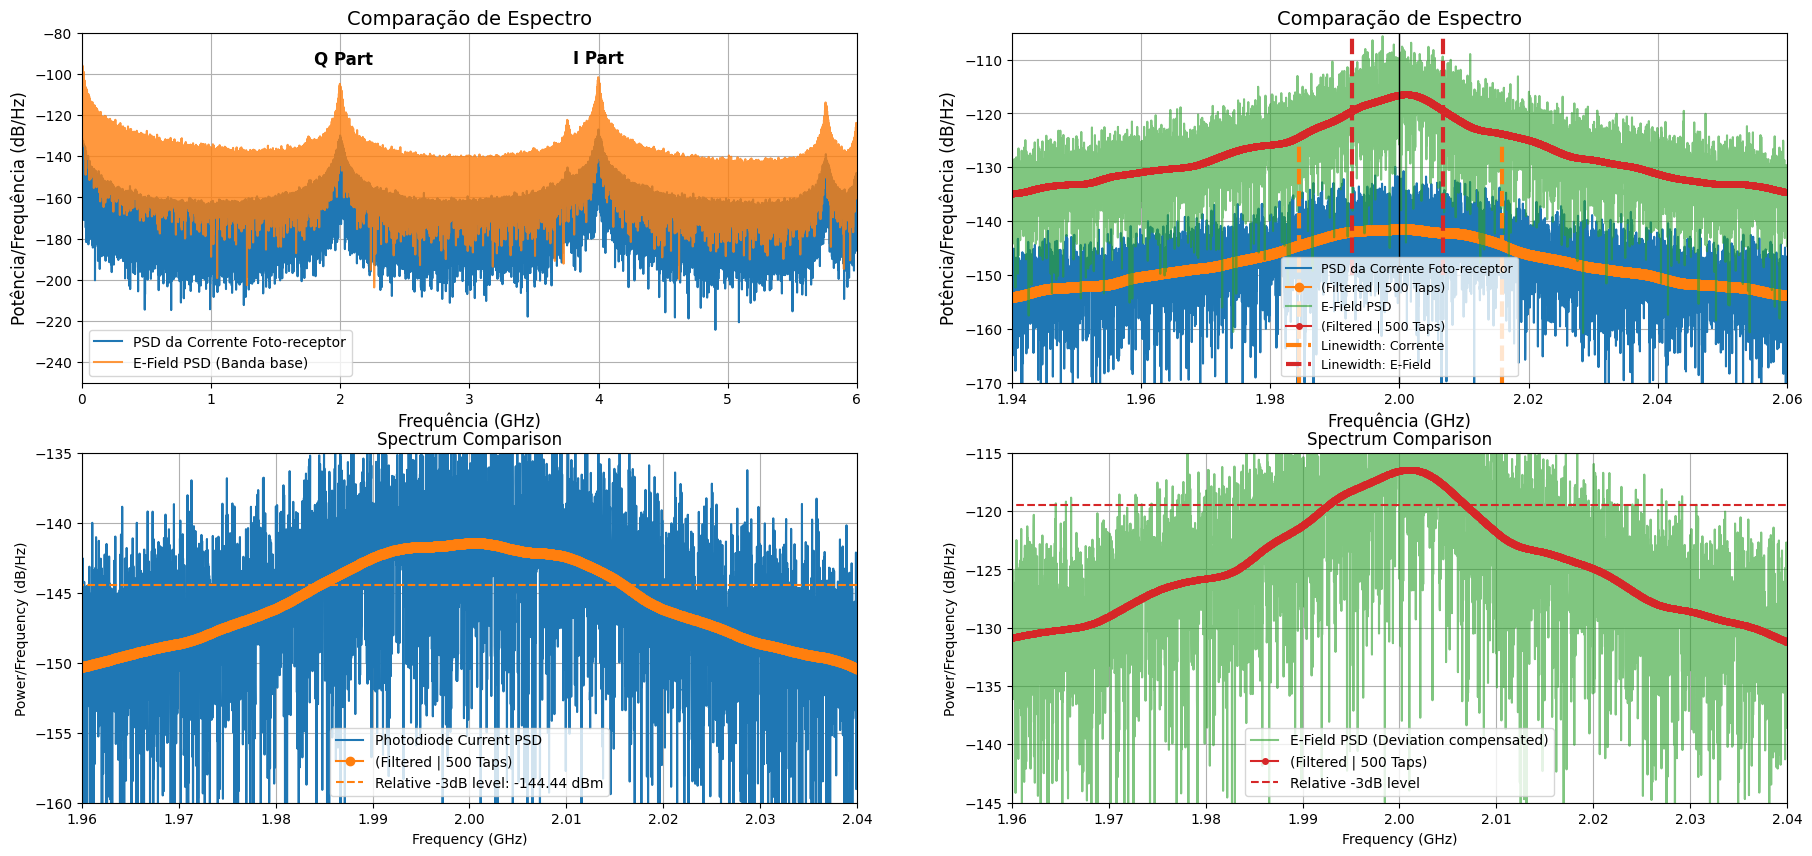

In [66]:
spectrum = len(IPd)*np.abs(np.fft.fft(IPd, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(IPd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

spectrum2 = len(Epd)*np.abs(np.fft.fft(Epd, norm='forward'))**2/Fs
freq2 = np.fft.fftfreq(len(Epd),d=1/Fs)
spectrum2 = 2*spectrum2[:int(len(freq2)/2)]
freq2 = freq2[:int(len(freq2)/2)]

spectrumDiff = 10*(np.max(np.log10(spectrum2))-np.max(np.log10(spectrum))) + 8

fig, ax = plt.subplots(2,2)
fig.set_figheight(10)
fig.set_figwidth(22)

ax[0][0].plot(freq*1e-9,10*np.log10(spectrum), label='PSD da Corrente Foto-receptor')
ax[0][0].plot((freq2)*1e-9,10*np.log10(spectrum2), label='E-Field PSD (Banda base)',alpha=0.8)
# ax[0][0].plot((freq2-DeviationFreq)*1e-9,10*np.log10(spectrum2), label='E-Field PSD (Deviation compensated)',alpha=0.6)
ax[0][0].text(1.8,-95,'Q Part',fontweight='bold',fontsize=12)
ax[0][0].text(3.8,-95,'I Part',fontweight='bold',fontsize=12)
ax[0][0].set_xlabel('Frequência (GHz)',fontsize=12)
ax[0][0].set_ylabel('Potência/Frequência (dB/Hz)',fontsize=12)
ax[0][0].set_xlim(2-2,2+4)
ax[0][0].set_ylim(-250,-80)
ax[0][0].set_title('Comparação de Espectro',fontsize=14)
ax[0][0].legend(fontsize=10)
ax[0][0].grid()


# Linewidth calculation ------------------------------------------------------------------------------------------

spectrum = len(IPd)*np.abs(np.fft.fft(IPd, norm='forward'))**2/Fs
freq = np.fft.fftfreq(len(IPd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

spectrum2 = len(Epd)*np.abs(np.fft.fft(Epd, norm='forward'))**2/Fs
freq2 = np.fft.fftfreq(len(Epd),d=1/Fs)-DeviationFreq
spectrum2 = 2*spectrum2[:int(len(freq2)/2)]
freq2 = freq2[:int(len(freq2)/2)]

Ntaps = 500
Ntaps2 = 500
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
b2 = signal.firwin(numtaps = Ntaps2, cutoff = 1e-5, window='hamming')
peakFreq = 2e9

centerFreq = peakFreq 
cutLims = [centerFreq - 100e6 , centerFreq + 100e6]

centerFreq2 = peakFreq
cutLims2 = [centerFreq2 - 100e6 , centerFreq2 + 100e6]

initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

initFreq2 = int((cutLims2[0]-freq2[0])/(freq2[-1]-freq2[0])*len(freq2))
endFreq2 = int((cutLims2[1]-freq2[0])/(freq2[-1]-freq2[0])*len(freq2))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(spectrum[initFreq:endFreq])
freq2 = freq2[initFreq2:endFreq2]
spectrum2 =  10*np.log10(spectrum2[initFreq2:endFreq2])

FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  
FilteredSpec2 = firFilter(b2, spectrum2)[Ntaps2:-Ntaps2]  

BestrightMark = 0
BestleftMark = 0
BestrightMark2 = 0
BestleftMark2 = 0

freq = freq[Ntaps:-Ntaps] 
freq2 = freq2[Ntaps2:-Ntaps2] 
spectrum = spectrum[Ntaps:-Ntaps] 
spectrum2 = spectrum2[Ntaps2:-Ntaps2] 

for i in range(len(FilteredSpec)-1):
    if FilteredSpec[i+1] > np.max(FilteredSpec)-3 and FilteredSpec[i] <= np.max(FilteredSpec)-3:
        # print(f'leftMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(leftMark-centerFreq) <= np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] <= np.max(FilteredSpec)-3 and FilteredSpec[i] > np.max(FilteredSpec)-3:
        # print(f'rightMark between {np.round(freq[i]*1e-6,2)} and {np.round(freq[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freq[i+1]-freq[i]) + freq[i]
        if (np.abs(rightMark-centerFreq) <= np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

for i in range(len(FilteredSpec2)-1):
    if FilteredSpec2[i+1] > np.max(FilteredSpec2)-3 and FilteredSpec2[i] <= np.max(FilteredSpec2)-3:
        # print(f'leftMark between {np.round(freq2[i]*1e-6,2)} and {np.round(freq2[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec2)-3-FilteredSpec2[i])/(FilteredSpec2[i+1]-FilteredSpec2[i]) * (freq2[i+1]-freq2[i]) + freq2[i]
        if (np.abs(leftMark-centerFreq2) <= np.abs(BestleftMark2-centerFreq2) and leftMark < centerFreq2):
            BestleftMark2 = leftMark
            print(f'BestleftMark2: {BestleftMark2*1e-6} MHz')
    elif FilteredSpec2[i+1] <= np.max(FilteredSpec2)-3 and FilteredSpec2[i] > np.max(FilteredSpec2)-3:
        # print(f'rightMark between {np.round(freq2[i]*1e-6,2)} and {np.round(freq2[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec2)-3-FilteredSpec2[i])/(FilteredSpec2[i+1]-FilteredSpec2[i]) * (freq2[i+1]-freq2[i]) + freq2[i]
        if (np.abs(rightMark-centerFreq2) <= np.abs(BestrightMark2-centerFreq2) and rightMark > centerFreq2):
            BestrightMark2 = rightMark
            print(f'BestrightMark2: {BestrightMark2*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
delF2 = BestrightMark2*1e-6-BestleftMark2*1e-6
display(Math('PD~Current~Linewidth(/2) = %5.6f~MHz~~|~~E-Field~Linewidth = %5.6f~MHz' %(delF/2, delF2)))


# Plotting ---------------------------------------------------------------

ax[0][1].plot(freq*1e-9,spectrum, label='PSD da Corrente Foto-receptor')
ax[0][1].plot(freq*1e-9,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
ax[0][1].plot((freq2)*1e-9,spectrum2-spectrumDiff, label='E-Field PSD',alpha=0.6,color='C2')
ax[0][1].plot(freq2*1e-9,FilteredSpec2-spectrumDiff,'-o', label=f'(Filtered | {Ntaps2} Taps)',color='C3',markersize=4)
ax[0][1].vlines(BestleftMark*1e-9,ymin=-170, ymax=-125, color='C1', linestyle='--', label=f'Linewidth: Corrente',linewidth=3)
ax[0][1].vlines(BestrightMark*1e-9,ymin=-170, ymax=-125, color='C1', linestyle='--',linewidth=3)
ax[0][1].vlines(BestleftMark2*1e-9,ymin=-150, ymax=-105, color='C3', linestyle='--', label=f'Linewidth: E-Field',linewidth=3)
ax[0][1].vlines(BestrightMark2*1e-9,ymin=-150, ymax=-105, color='C3', linestyle='--',linewidth=3)
ax[0][1].vlines(centerFreq*1e-9,ymin=-170, ymax=-105, color='black', linestyle='-',linewidth=1)
ax[0][1].set_xlabel('Frequência (GHz)',fontsize=12)
ax[0][1].set_ylabel('Potência/Frequência (dB/Hz)',fontsize=12)
ax[0][1].set_title('Comparação de Espectro',fontsize=14)
ax[0][1].set_xlim(2-0.06,2+0.06)
ax[0][1].set_ylim(-170,-105)
ax[0][1].legend(fontsize=9)
ax[0][1].grid()

ax[1][0].plot(freq*1e-9,spectrum, label='Photodiode Current PSD')
ax[1][0].plot(freq*1e-9,FilteredSpec,'-o', label=f'(Filtered | {Ntaps} Taps)')
ax[1][0].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='C1', linestyle='--', label=f'Relative -3dB level: {np.round(np.max(FilteredSpec)-3,2)} dBm')
ax[1][0].set_xlabel('Frequency (GHz)')
ax[1][0].set_ylabel('Power/Frequency (dB/Hz)')
ax[1][0].set_title('Spectrum Comparison')
ax[1][0].set_xlim(2-0.04,2+0.04)
ax[1][0].set_ylim(-160,-135)
ax[1][0].legend()
ax[1][0].grid()

ax[1][1].plot((freq2)*1e-9,spectrum2-spectrumDiff, label='E-Field PSD (Deviation compensated)',alpha=0.6,color='C2')
ax[1][1].plot(freq2*1e-9,FilteredSpec2-spectrumDiff,'-o', label=f'(Filtered | {Ntaps2} Taps)',color='C3',markersize=4)
ax[1][1].hlines(np.max(FilteredSpec2)-3-spectrumDiff,xmin=cutLims2[0]*1e-9, xmax=cutLims2[1]*1e-9, color='C3', linestyle='--', label=f'Relative -3dB level')
ax[1][1].set_xlabel('Frequency (GHz)')
ax[1][1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1][1].set_title('Spectrum Comparison')
ax[1][1].set_xlim(2-0.04,2+0.04)
ax[1][1].set_ylim(-145,-115)
ax[1][1].legend()
ax[1][1].grid()

plt.savefig("SpectrumComparison_Lorentz2.pdf", format="pdf")

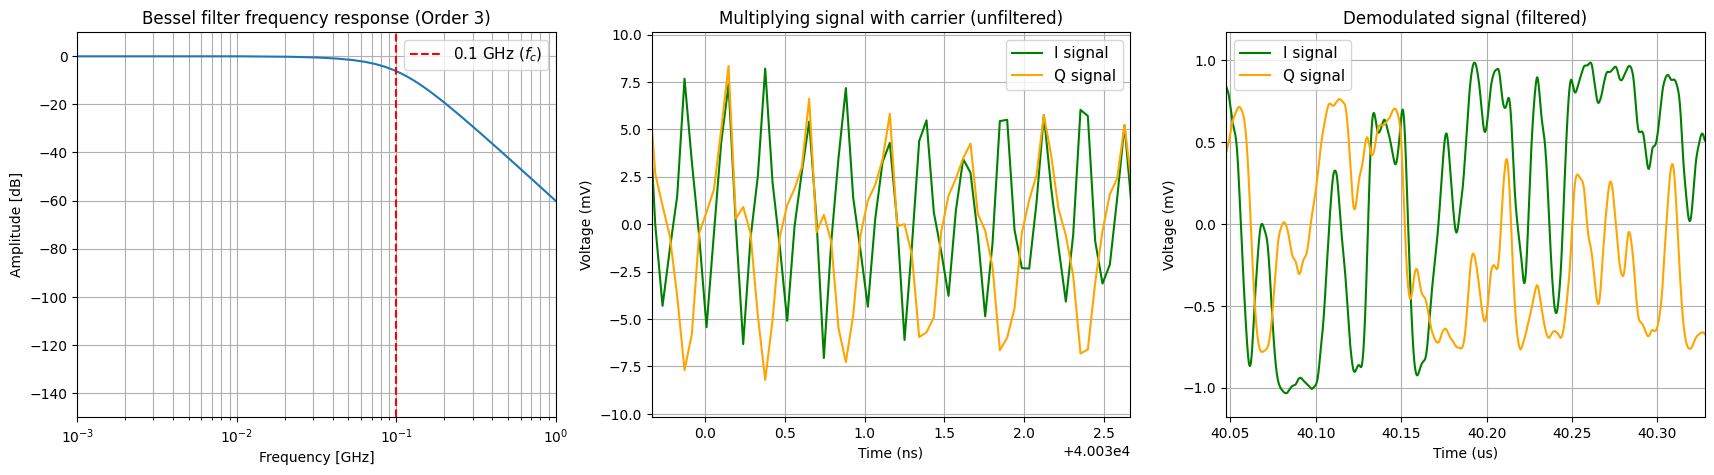

In [67]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(21)

StTime = np.min(timeArray*1e9) # Starting time post delay

ax[0].plot(w*1e-9, 20 * np.log10(abs(h)))
ax[0].axvline(DemodCutFreq*1e-9, color='red', linestyle='--', label=f'{DemodCutFreq*1e-9} GHz ($f_c$)')
ax[0].set_xscale('log')
ax[0].set_xlim(0.001,1)
ax[0].set_ylim(-150,10)
ax[0].set_title(f'Bessel filter frequency response (Order {Demodorder})')
ax[0].set_xlabel('Frequency [GHz]')
ax[0].set_ylabel('Amplitude [dB]')
ax[0].margins(0, 0.1)
ax[0].grid(which='both', axis='both')
ax[0].legend(fontsize=11)

ax[1].plot(timeArray*1e9,I_Sig*1e3, label='I signal', color='green')
ax[1].plot(timeArray*1e9,Q_Sig*1e3, label='Q signal', color='orange')
ax[1].set_xlim(StTime+2,StTime+5)
ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('Voltage (mV)')
ax[1].set_title('Multiplying signal with carrier (unfiltered)')
ax[1].grid()
ax[1].legend(fontsize=11)

ax[2].plot(timeArray*1e6,FilteredI_Sig*1e3, label='I signal', color='green')
ax[2].plot(timeArray*1e6,FilteredQ_Sig*1e3, label='Q signal', color='orange')
ax[2].set_xlim(StTime*1e-3+0.02,StTime*1e-3+0.3)
ax[2].set_xlabel('Time (us)')
ax[2].set_ylabel('Voltage (mV)')
ax[2].set_title('Demodulated signal (filtered)')
ax[2].grid()
ax[2].legend(fontsize=11)

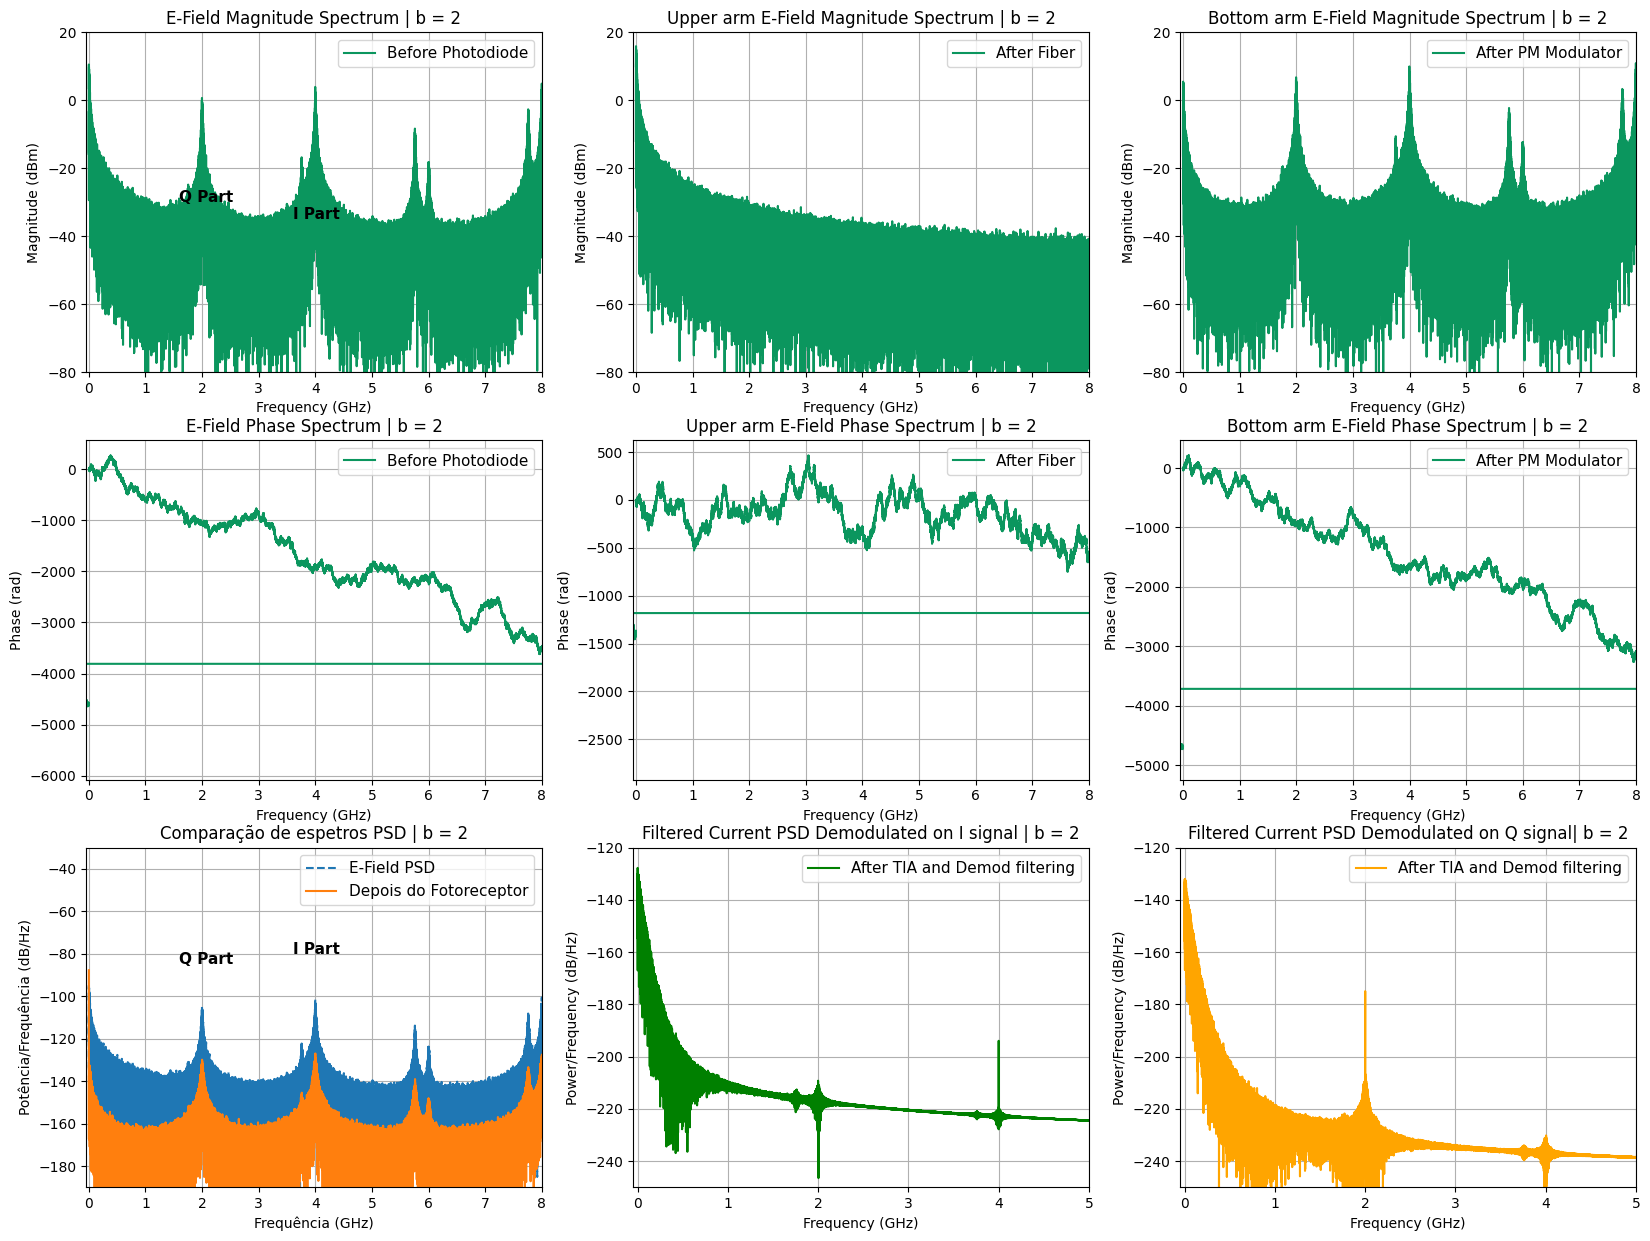

In [68]:
fig, ax = plt.subplots(3,3)
fig.set_figheight(15)
fig.set_figwidth(20)

StTime = np.min(timeArray*1e12) # Starting time post delay

# spectrum, freq = mlab.magnitude_spectrum(Epd, Fs=Fs, window=mlab.window_none,sides='onesided')
spectrum = np.abs(np.fft.fft(Epd,norm='forward'))
freq = np.fft.fftfreq(len(Epd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
ax[0][0].plot(freq*1e-9,20*np.log10(spectrum*1e3), label='Before Photodiode', color='#0b965e')
# ax[0][0].magnitude_spectrum(Epd, Fs=Fs, color='C1', window=mlab.window_none)
ax[0][0].text(1.6,-30,'Q Part',fontweight='bold',fontsize=11)
ax[0][0].text(3.6,-35,'I Part',fontweight='bold',fontsize=11)
ax[0][0].set_xlabel('Frequency (GHz)')
ax[0][0].set_ylabel('Magnitude (dBm)')
ax[0][0].set_xlim(-0.05,8)
ax[0][0].set_ylim(-80,20)
ax[0][0].set_title(f'E-Field Magnitude Spectrum | b = {bIdx}')
ax[0][0].grid()
ax[0][0].legend(fontsize=11)

# spectrum, freq = mlab.magnitude_spectrum(EUpper, Fs=Fs, window=mlab.window_none,sides='onesided')
spectrum = np.abs(np.fft.fft(EUpper,norm='forward'))
freq = np.fft.fftfreq(len(EUpper),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
ax[0][1].plot(freq*1e-9,20*np.log10(spectrum*1e3), label='After Fiber', color='#0b965e')
ax[0][1].set_xlabel('Frequency (GHz)')
ax[0][1].set_ylabel('Magnitude (dBm)')
ax[0][1].set_xlim(-0.05,8)
ax[0][1].set_ylim(-80,20)
ax[0][1].set_title(f'Upper arm E-Field Magnitude Spectrum | b = {bIdx}')
ax[0][1].grid()
ax[0][1].legend(fontsize=11)

# spectrum, freq = mlab.magnitude_spectrum(EBottom, Fs=Fs, window=mlab.window_none,sides='onesided')
spectrum = np.abs(np.fft.fft(EBottom,norm='forward'))
freq = np.fft.fftfreq(len(EBottom),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
ax[0][2].plot(freq*1e-9,20*np.log10(spectrum*1e3), label='After PM Modulator', color='#0b965e')
ax[0][2].set_xlabel('Frequency (GHz)')
ax[0][2].set_ylabel('Magnitude (dBm)')
ax[0][2].set_xlim(-0.05,8)
ax[0][2].set_ylim(-80,20)
ax[0][2].set_title(f'Bottom arm E-Field Magnitude Spectrum | b = {bIdx}')
ax[0][2].grid()
ax[0][2].legend(fontsize=11)

freq = np.fft.fftfreq(len(Epd), d=1/Fs)
spectrumAngle = np.angle(np.fft.fft(Epd,norm='forward'))
ax[1][0].plot(freq*1e-9,np.unwrap(spectrumAngle), label='Before Photodiode', color='#0b965e')
ax[1][0].set_xlabel('Frequency (GHz)')
ax[1][0].set_ylabel('Phase (rad)')
ax[1][0].set_xlim(-0.05,8)
# ax[1][0].set_ylim(-800,800)
ax[1][0].set_title(f'E-Field Phase Spectrum | b = {bIdx}')
ax[1][0].grid()
ax[1][0].legend(fontsize=11)

freq = np.fft.fftfreq(len(EUpper), d=1/Fs)
spectrumAngle = np.angle(np.fft.fft(EUpper,norm='forward'))
ax[1][1].plot(freq*1e-9,np.unwrap(spectrumAngle), label='After Fiber', color='#0b965e')
ax[1][1].set_xlabel('Frequency (GHz)')
ax[1][1].set_ylabel('Phase (rad)')
ax[1][1].set_xlim(-0.05,8)
# ax[1][1].set_ylim(-500,1000)
ax[1][1].set_title(f'Upper arm E-Field Phase Spectrum | b = {bIdx}')
ax[1][1].grid()
ax[1][1].legend(fontsize=11)

freq = np.fft.fftfreq(len(EBottom), d=1/Fs)
spectrumAngle = np.angle(np.fft.fft(EBottom,norm='forward'))
ax[1][2].plot(freq*1e-9,np.unwrap(spectrumAngle), label='After PM Modulator', color='#0b965e')
ax[1][2].set_xlabel('Frequency (GHz)')
ax[1][2].set_ylabel('Phase (rad)')
ax[1][2].set_xlim(-0.05,8)
# ax[1][2].set_ylim(-800,200)
ax[1][2].set_title(f'Bottom arm E-Field Phase Spectrum | b = {bIdx}')
ax[1][2].grid()
ax[1][2].legend(fontsize=11)

# AFTER PHOTODIODE ---------------------------------------------------------------------

spectrum = len(Epd)*np.abs(np.fft.fft(FilteredIPd,norm='forward'))**2 / Fs
freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]

spectrum2 = len(Epd)*np.abs(np.fft.fft(Epd,norm='forward'))**2 / Fs
freq2 = np.fft.fftfreq(len(Epd),d=1/Fs)
spectrum2 = 2*spectrum2[:int(len(freq2)/2)]
freq2 = freq2[:int(len(freq2)/2)]

ax[2][0].plot(freq2*1e-9,10*np.log10(spectrum2), label='E-Field PSD',linestyle='--')
ax[2][0].plot(freq*1e-9,10*np.log10(spectrum), label='Depois do Fotoreceptor')
ax[2][0].text(1.6,-85,'Q Part',fontweight='bold',fontsize=11)
ax[2][0].text(3.6,-80,'I Part',fontweight='bold',fontsize=11)
ax[2][0].set_xlabel('Frequência (GHz)')
ax[2][0].set_ylabel('Potência/Frequência (dB/Hz)')
ax[2][0].set_xlim(-0.05,8)
ax[2][0].set_ylim(-190,-30)
ax[2][0].set_title(f'Comparação de espetros PSD | b = {bIdx}')
ax[2][0].grid()
ax[2][0].legend(fontsize=11)

spectrum = len(FilteredI_Sig)*np.abs(np.fft.fft(FilteredI_Sig,norm='forward'))**2 / Fs
freq = np.fft.fftfreq(len(FilteredI_Sig),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
ax[2][1].plot(freq*1e-9,10*np.log10(spectrum), label='After TIA and Demod filtering', color='green')
ax[2][1].set_xlabel('Frequency (GHz)')
ax[2][1].set_ylabel('Power/Frequency (dB/Hz)')
ax[2][1].set_xlim(-0.05,5)
ax[2][1].set_ylim(-250,-120)
ax[2][1].set_title(f'Filtered Current PSD Demodulated on I signal | b = {bIdx}')
ax[2][1].grid()
ax[2][1].legend(fontsize=11)

spectrum = len(FilteredQ_Sig)*np.abs(np.fft.fft(FilteredQ_Sig,norm='forward'))**2 / Fs
freq = np.fft.fftfreq(len(FilteredQ_Sig),d=1/Fs)
spectrum = 2*spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
ax[2][2].plot(freq*1e-9, 10*np.log10(spectrum), label='After TIA and Demod filtering', color='orange')
ax[2][2].set_xlabel('Frequency (GHz)')
ax[2][2].set_ylabel('Power/Frequency (dB/Hz)')
ax[2][2].set_xlim(-0.05,5)
ax[2][2].set_ylim(-250,-120)
ax[2][2].set_title(f'Filtered Current PSD Demodulated on Q signal| b = {bIdx}')
ax[2][2].grid()
ax[2][2].legend(fontsize=11)

# Linewidth Characterization

## E-Field PSD

In [174]:
spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd,norm='forward'))**2 / Fs
freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)

print(f'len spectrum: {len(spectrum[:int(len(freq)/2)])}')
print(f'len freq: {len(freq[:int(len(freq)/2)])}')
newfreq = freq[:int(len(freq)/2)]
print(f'freq[0] = {newfreq[0]} | freq[-1] = {newfreq[-1]*1e-9} GHz')

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]
initFreq = int((cutLims[0]-newfreq[0])/(newfreq[-1]-newfreq[0])*len(newfreq))
endFreq = int((cutLims[1]-newfreq[0])/(newfreq[-1]-newfreq[0])*len(newfreq))

print(f'initfreq = {initFreq} | endfreq = {endFreq}')

len spectrum: 613075
len freq: 613075
freq[0] = 0.0 | freq[-1] = 10.879982253394772 GHz
initfreq = 81705 | endfreq = 143689


In [70]:
tapsArray

array([ 300.        ,  368.42105263,  436.84210526,  505.26315789,
        573.68421053,  642.10526316,  710.52631579,  778.94736842,
        847.36842105,  915.78947368,  984.21052632, 1052.63157895,
       1121.05263158, 1189.47368421, 1257.89473684, 1326.31578947,
       1394.73684211, 1463.15789474, 1531.57894737, 1600.        ])

leftMark between 1982.95 and 1982.97 MHz
BestleftMark: 1982.9591870038155 MHz
rightMark between 2017.24 and 2017.26 MHz
BestrightMark: 2017.2529092000768 MHz


<IPython.core.display.Math object>

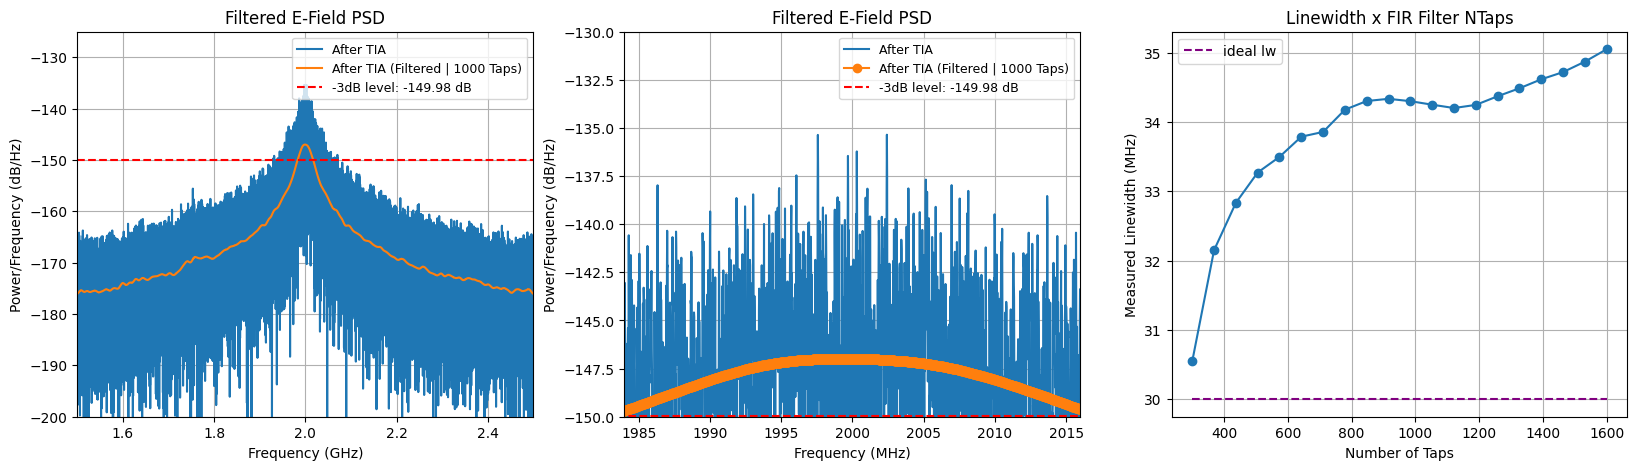

In [175]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

tapsArray = np.linspace(300,1600,20)
lwArray = np.zeros(len(tapsArray))

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]

# spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd,norm='forward'))**2 / Fs
# freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)
win = np.hamming(len(FilteredIPd))                       
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
FilteredIPd_win = FilteredIPd * win  
spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)


spectrum = spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 1000
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

ax[0].plot(freq*1e-9,spectrum, label='After TIA')
ax[0].plot(freq[Ntaps:-Ntaps]*1e-9,FilteredSpec, label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[0].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Power/Frequency (dB/Hz)')
ax[0].set_xlim(1.5,2.5)
ax[0].set_ylim(-200,-125)
ax[0].set_title(f'Filtered E-Field PSD')
ax[0].grid()
ax[0].legend(fontsize=9)

ax[1].plot(freq*1e-6,spectrum, label='After TIA')
ax[1].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[1].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1].set_xlim(2000 - 16 , 2000 + 16)
ax[1].set_ylim(-150,-130)
ax[1].set_title(f'Filtered E-Field PSD')
ax[1].grid()
ax[1].legend(fontsize=9)

BestrightMark = 0
BestleftMark = 0

freqCutted = freq[Ntaps:-Ntaps].copy()

for i in range(len(FilteredSpec)-1):
    leftMark = 0
    rightMark = 0
    if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
        print(f'leftMark between {np.round(freqCutted[i]*1e-6,2)} and {np.round(freqCutted[i+1]*1e-6,2)} MHz')
        leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
        if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
            BestleftMark = leftMark
            print(f'BestleftMark: {BestleftMark*1e-6} MHz')
    elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
        print(f'rightMark between {np.round(freqCutted[i]*1e-6,2)} and {np.round(freqCutted[i+1]*1e-6,2)} MHz')
        rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
        if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
            BestrightMark = rightMark
            print(f'BestrightMark: {BestrightMark*1e-6} MHz')

delF = BestrightMark*1e-6-BestleftMark*1e-6
display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(delF, delF/2 )))

for j in range(len(tapsArray)):
    NtapsIt = int(np.floor(tapsArray[j]))
    b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

    BestrightMark = 0
    BestleftMark = 0

    freqCutted = freq[NtapsIt:-NtapsIt].copy()

    for i in range(len(FilteredSpec)-1):
        leftMark = 0
        rightMark = 0
        if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
            leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
                BestleftMark = leftMark
                # print(f'new bestleft = {BestleftMark}')
        elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
            rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
                BestrightMark = rightMark
                # print(f'new bestright = {BestrightMark}')
        # print(f'left and right: {leftMark} | {rightMark}')
    
    lwArray[j] = BestrightMark*1e-6-BestleftMark*1e-6

ax[2].plot(tapsArray,lwArray,'-o')
ax[2].set_xlabel('Number of Taps')
ax[2].set_ylabel('Measured Linewidth (MHz)')
ax[2].set_title(f'Linewidth x FIR Filter NTaps')
# ax[2].hlines(delF,xmin=tapsArray[0], xmax=tapsArray[-1], color='red', linestyle='--', label=f'Measured lw with ({Ntaps} taps)')
ax[2].hlines(laser_parameters.lw*2e-6,xmin=tapsArray[0], xmax=tapsArray[-1], color='purple', linestyle='--', label=f'ideal lw')
ax[2].grid()
ax[2].legend(fontsize=10)

plt.savefig("FWHMTapsVariation.pdf", format="pdf")

<IPython.core.display.Math object>

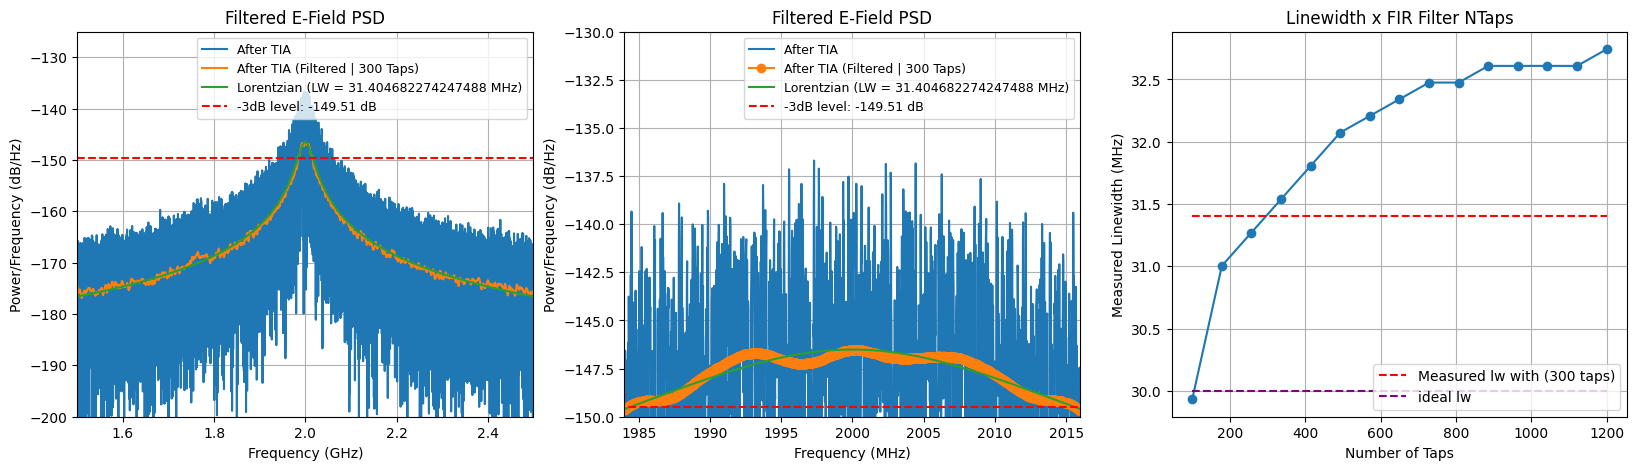

In [72]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]

win = np.hamming(len(FilteredIPd))                       
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
FilteredIPd_win = FilteredIPd * win  
spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)

# spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd,norm='forward'))**2 / Fs
# freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)

spectrum = spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])

# Filter spectrum
Ntaps = 300
b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

LorentzLWArray = np.linspace(10e6,50e6,300)
corArray = np.zeros(len(LorentzLWArray))

for i in range(len(LorentzLWArray)):
    delV = LorentzLWArray[i]
    LorentzS = 10*np.log10(1/(2*np.pi) * delV/((freq - centerFreq)**2 + (delV/2)**2))
    LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))
    corArray[i] = np.sum(np.abs(LorentzS[Ntaps:-Ntaps] - FilteredSpec)**2)

delV = LorentzLWArray[np.argmin(corArray)]
LorentzS = 10*np.log10(1/(2*np.pi) * delV/((freq - centerFreq)**2 + (delV/2)**2))
LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))

ax[0].plot(freq*1e-9,spectrum, label='After TIA')
ax[0].plot(freq[Ntaps:-Ntaps]*1e-9,FilteredSpec, label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[0].plot(freq[Ntaps:-Ntaps]*1e-9,LorentzS[Ntaps:-Ntaps], label=f'Lorentzian (LW = {delV*1e-6} MHz)')
ax[0].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-9, xmax=cutLims[1]*1e-9, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('Power/Frequency (dB/Hz)')
ax[0].set_xlim(1.5,2.5)
ax[0].set_ylim(-200,-125)
ax[0].set_title(f'Filtered E-Field PSD')
ax[0].grid()
ax[0].legend(fontsize=9)

ax[1].plot(freq*1e-6,spectrum, label='After TIA')
ax[1].plot(freq[Ntaps:-Ntaps]*1e-6,FilteredSpec,'-o', label=f'After TIA (Filtered | {Ntaps} Taps)')
ax[1].plot(freq[Ntaps:-Ntaps]*1e-6,LorentzS[Ntaps:-Ntaps], label=f'Lorentzian (LW = {delV*1e-6} MHz)')
ax[1].hlines(np.max(FilteredSpec)-3,xmin=cutLims[0]*1e-6, xmax=cutLims[1]*1e-6, color='red', linestyle='--', label=f'-3dB level: {np.round(np.max(FilteredSpec)-3,2)} dB')
ax[1].set_xlabel('Frequency (MHz)')
ax[1].set_ylabel('Power/Frequency (dB/Hz)')
ax[1].set_xlim(2000 - 16 , 2000 + 16)
ax[1].set_ylim(-150,-130)
ax[1].set_title(f'Filtered E-Field PSD')
ax[1].grid()
ax[1].legend(fontsize=9)

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(delV*1e-6, delV*1e-6/2 )))

tapsArray = np.linspace(100,1200,15)
lwArray = np.zeros(len(tapsArray))

for j in range(len(tapsArray)):
    NtapsIt = int(tapsArray[j])
    b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

    for i in range(len(LorentzLWArray)):
        delVit = LorentzLWArray[i]
        LorentzS = 10*np.log10(1/(2*np.pi) * delVit/((freq - centerFreq)**2 + (delVit/2)**2))
        LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))
        corArray[i] = np.sum(np.abs(LorentzS[NtapsIt:-NtapsIt] - FilteredSpec)**2)

    lwArray[j] = LorentzLWArray[np.argmin(corArray)]*1e-6

ax[2].plot(tapsArray,lwArray,'-o')
ax[2].set_xlabel('Number of Taps')
ax[2].set_ylabel('Measured Linewidth (MHz)')
ax[2].set_title(f'Linewidth x FIR Filter NTaps')
ax[2].hlines(delV*1e-6,xmin=tapsArray[0], xmax=tapsArray[-1], color='red', linestyle='--', label=f'Measured lw with ({Ntaps} taps)')
ax[2].hlines(laser_parameters.lw*2e-6,xmin=tapsArray[0], xmax=tapsArray[-1], color='purple', linestyle='--', label=f'ideal lw')
ax[2].grid()
ax[2].legend(fontsize=10)

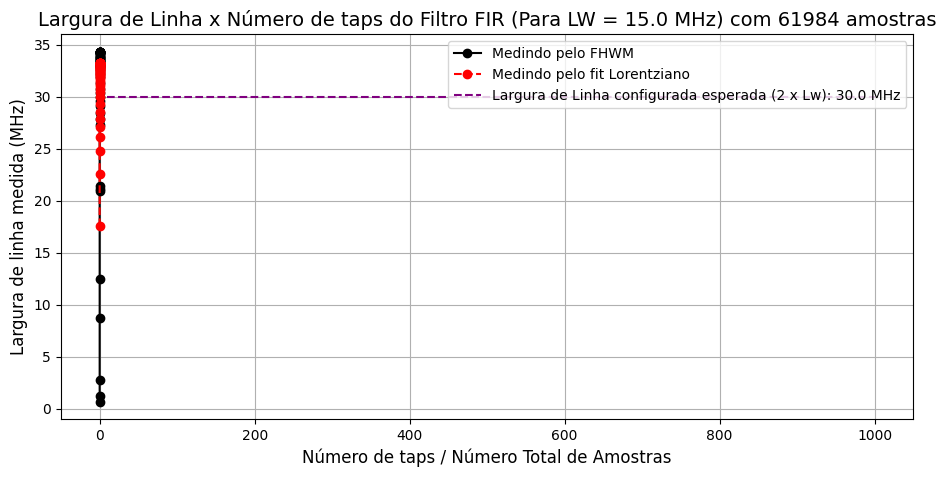

In [ ]:
tapsArray = np.linspace(10,1000,50)
lwArray = np.zeros(len(tapsArray))
lwArray2 = np.zeros(len(tapsArray))

LorentzLWArray = np.linspace(1e6,45e6,1000)

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]

# spectrum = len(FilteredIPd)*np.abs(np.fft.fft(FilteredIPd,norm='forward'))**2 / Fs
# freq = np.fft.fftfreq(len(FilteredIPd),d=1/Fs)

win = np.hamming(len(FilteredIPd))                       
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
FilteredIPd_win = FilteredIPd * win  
spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)

spectrum = spectrum[:int(len(freq)/2)]
freq = freq[:int(len(freq)/2)]
initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

freq = freq[initFreq:endFreq]
spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])
TotalN = len(spectrum)

for j in range(len(tapsArray)):
    NtapsIt = int(np.floor(tapsArray[j]))
    b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

    BestrightMark = 0
    BestleftMark = 0

    freqCutted = freq[NtapsIt:-NtapsIt].copy()

    for i in range(len(FilteredSpec)-1):
        if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
            leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
                BestleftMark = leftMark
        elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
            rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
                BestrightMark = rightMark
    
    lwArray[j] = BestrightMark*1e-6-BestleftMark*1e-6

    corArray = np.zeros(len(LorentzLWArray))

    for i in range(len(LorentzLWArray)):
        delVit = LorentzLWArray[i]
        LorentzS = 10*np.log10(1/(2*np.pi) * delVit/((freq - centerFreq)**2 + (delVit/2)**2))
        LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))
        corArray[i] = np.sum(np.abs(LorentzS[NtapsIt:-NtapsIt] - FilteredSpec)**2)

    lwArray2[j] = LorentzLWArray[np.argmin(corArray)]*1e-6

plt.figure(figsize=(11,5))
plt.plot(tapsArray/TotalN,lwArray,'-o',label='Medindo pelo FHWM', color='black')
plt.plot(tapsArray/TotalN,lwArray2,'--o',label='Medindo pelo fit Lorentziano', color='red')
plt.xlabel('Número de taps / Número Total de Amostras',fontsize=12)
plt.ylabel('Largura de linha medida (MHz)',fontsize=12)
plt.title(f'Largura de Linha x Número de taps do Filtro FIR (Para LW = {laser_parameters.lw*1e-6} MHz) com {int(TotalN)} amostras',fontsize=14)
plt.hlines(laser_parameters.lw*2e-6,xmin=tapsArray[0]/TotalN, xmax=tapsArray[-1]/TotalN, color='purple', linestyle='--', label=f'Largura de Linha configurada esperada (2 x Lw): {laser_parameters.lw * 2e-6} MHz')
plt.grid()
plt.legend(fontsize=10)

plt.savefig("FWHMxLorentzianFit3.pdf", format="pdf")

### FWHM comparison

Sweeping through linewidths... :   0%|          | 0/5 [00:00<?, ?it/s]

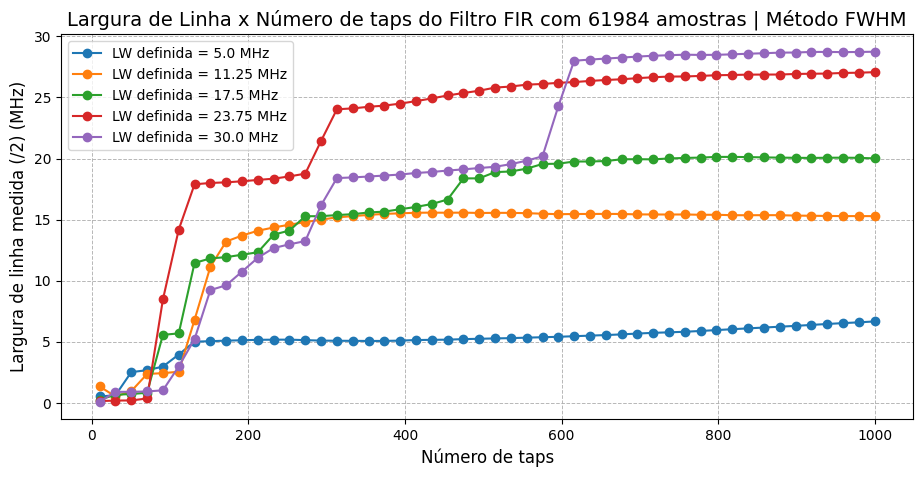

In [228]:
tapsArray = np.linspace(10,1000,50)
DefLwArray = np.linspace(5e6,30e6,5)
lwMatrix = np.zeros((len(tapsArray),len(DefLwArray)))

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]

progress_bar = tqdm(total=len(DefLwArray), desc="Sweeping through linewidths... ")

for k in range(len(DefLwArray)):

    laser_parameters.lw = DefLwArray[k]  # laser linewidth [Hz] 
    OptSig = basicLaserModel(laser_parameters)
    EUpper = linearFiberChannel(OptSig*np.sqrt(KConst),LinearFiber_parameters) # Upper arm Optical signal post fiber 
    EUpper = shift(EUpper,shiftValue,cval=EUpper[0]) # Applying delay
    EUpper = EUpper[shiftValue:]

    carrier = OptSig*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
    EBottom = pm(carrier,elecSig,vPi)  # PM modulation
    EBottom = EBottom[shiftValue:]

    Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
    Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

    IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode

    w_norm = TIACutFreq / (Fs/2)
    b,a = signal.bessel(N=TIAorder, Wn=w_norm, btype='low', norm='phase')
    w, h = signal.freqz(b, a, worN=1024, fs=Fs)
    FilteredIPd = signal.lfilter(b, a, IPd)

    win = np.hamming(len(FilteredIPd))                       
    ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
    FilteredIPd_win = FilteredIPd * win  
    spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
    freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)

    spectrum = spectrum[:int(len(freq)/2)]
    freq = freq[:int(len(freq)/2)]
    initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
    endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

    freq = freq[initFreq:endFreq]
    spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])
    TotalN = len(spectrum)

    
    for j in range(len(tapsArray)):
        NtapsIt = int(np.floor(tapsArray[j]))
        b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
        FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

        BestrightMark = 0
        BestleftMark = 0

        freqCutted = freq[NtapsIt:-NtapsIt].copy()

        for i in range(len(FilteredSpec)-1):
            leftMark = 0
            rightMark = 0
            if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
                leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
                if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
                    BestleftMark = leftMark
            elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
                rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
                if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
                    BestrightMark = rightMark
        
        lwMatrix[j,k] = BestrightMark*1e-6-BestleftMark*1e-6

    progress_bar.update(1)  # Updates progress bar

plt.figure(figsize=(11,5))
for i in range(len(DefLwArray)):
    plt.plot(tapsArray,lwMatrix[:,i]/2,'-o',label=f'LW definida = {DefLwArray[i]*1e-6} MHz')

plt.xlabel('Número de taps',fontsize=12)
plt.ylabel('Largura de linha medida (/2) (MHz)',fontsize=12)
plt.title(f'Largura de Linha x Número de taps do Filtro FIR com {int(TotalN)} amostras | Método FWHM',fontsize=14)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.9)
plt.legend(fontsize=10)

plt.savefig("FWHMSweep.pdf", format="pdf")

### Lorentzian Comparison

Sweeping through linewidths... :   0%|          | 0/5 [00:00<?, ?it/s]

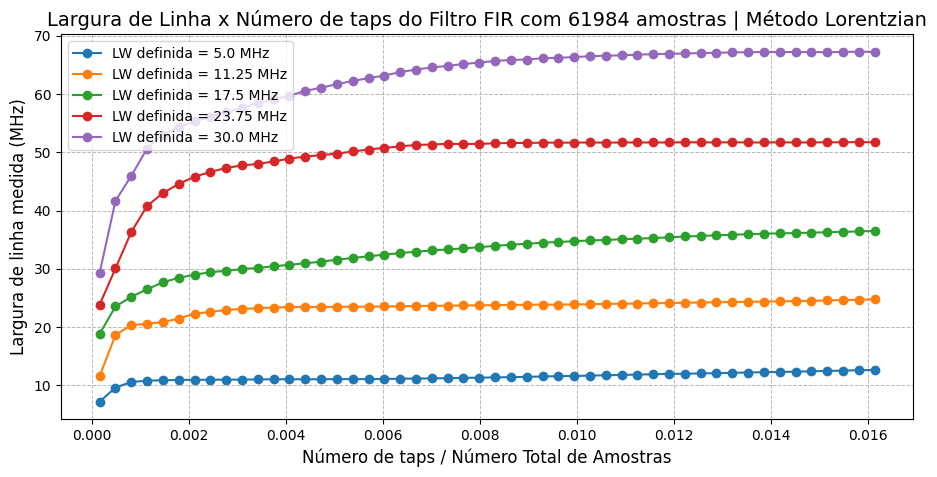

In [226]:
tapsArray = np.linspace(10,1000,50)
DefLwArray = np.linspace(5e6,30e6,5)
lwMatrix = np.zeros((len(tapsArray),len(DefLwArray)))

LorentzLWArray = np.linspace(1e6,90e6,3000)

centerFreq = 2e9
cutLims = [1.45e9,2.55e9]

progress_bar = tqdm(total=len(DefLwArray), desc="Sweeping through linewidths... ")

for k in range(len(DefLwArray)):

    laser_parameters.lw = DefLwArray[k]  # laser linewidth [Hz] 
    OptSig = basicLaserModel(laser_parameters)
    EUpper = linearFiberChannel(OptSig*np.sqrt(KConst),LinearFiber_parameters) # Upper arm Optical signal post fiber 
    EUpper = shift(EUpper,shiftValue,cval=EUpper[0]) # Applying delay
    EUpper = EUpper[shiftValue:]

    carrier = OptSig*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
    EBottom = pm(carrier,elecSig,vPi)  # PM modulation
    EBottom = EBottom[shiftValue:]

    Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
    Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

    IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode

    w_norm = TIACutFreq / (Fs/2)
    b,a = signal.bessel(N=TIAorder, Wn=w_norm, btype='low', norm='phase')
    w, h = signal.freqz(b, a, worN=1024, fs=Fs)
    FilteredIPd = signal.lfilter(b, a, IPd)

    win = np.hamming(len(FilteredIPd))                       
    ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
    FilteredIPd_win = FilteredIPd * win  
    spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
    freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)

    spectrum = spectrum[:int(len(freq)/2)]
    freq = freq[:int(len(freq)/2)]
    initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
    endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

    freq = freq[initFreq:endFreq]
    spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])
    TotalN = len(spectrum)

    for j in range(len(tapsArray)):
        NtapsIt = int(np.floor(tapsArray[j]))
        b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
        FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt]  

        for i in range(len(LorentzLWArray)):
            delVit = LorentzLWArray[i]
            LorentzS = 10*np.log10(1/(2*np.pi) * delVit/((freq - centerFreq)**2 + (delVit/2)**2))
            LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))
            corArray[i] = np.sum(np.abs(LorentzS[NtapsIt:-NtapsIt] - FilteredSpec)**2)

        lwMatrix[j,k] = LorentzLWArray[np.argmin(corArray)]*1e-6
    

    progress_bar.update(1)  # Updates progress bar

plt.figure(figsize=(11,5))
for i in range(len(DefLwArray)):
    plt.plot(tapsArray/TotalN,lwMatrix[:,i],'-o',label=f'LW definida = {DefLwArray[i]*1e-6} MHz')

plt.xlabel('Número de taps / Número Total de Amostras',fontsize=12)
plt.ylabel('Largura de linha medida (MHz)',fontsize=12)
plt.title(f'Largura de Linha x Número de taps do Filtro FIR com {int(TotalN)} amostras | Método Lorentzian',fontsize=14)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.9)
plt.legend(fontsize=10)

plt.savefig("LorentzianSweep.pdf", format="pdf")

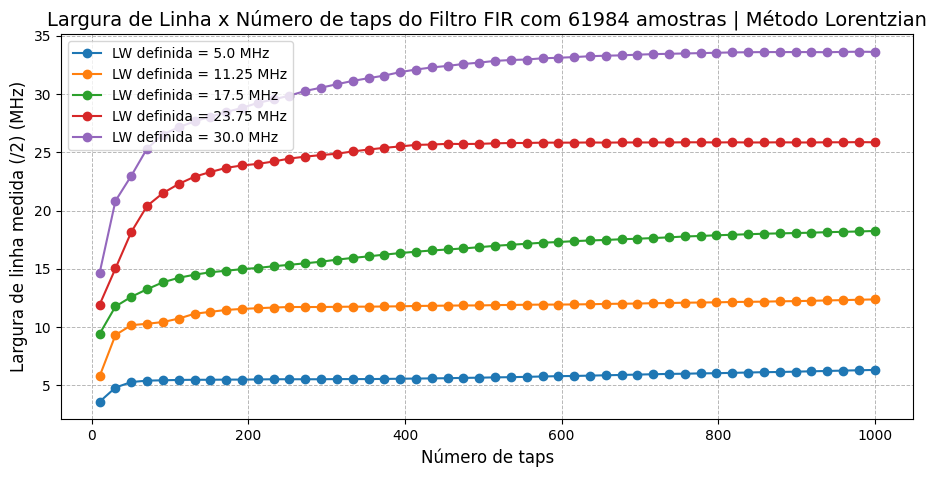

In [227]:
plt.figure(figsize=(11,5))
for i in range(len(DefLwArray)):
    plt.plot(tapsArray,lwMatrix[:,i]/2,'-o',label=f'LW definida = {DefLwArray[i]*1e-6} MHz')

plt.xlabel('Número de taps',fontsize=12)
plt.ylabel('Largura de linha medida (/2) (MHz)',fontsize=12)
plt.title(f'Largura de Linha x Número de taps do Filtro FIR com {int(TotalN)} amostras | Método Lorentzian',fontsize=14)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.9)
plt.legend(fontsize=10)

plt.savefig("LorentzianSweep.pdf", format="pdf")

## Frequency Modulation Noise Spectrum

Fs = 21.76 GSamples/s
1.3628266020618311
[0.00000000e+00 1.80408739e+04 3.60817477e+04 ... 1.08799459e+10
 1.08799639e+10 1.08799820e+10]


C:\Users\Caio\AppData\Local\Temp\ipykernel_16024\3052174611.py:75: RuntimeWarning: invalid value encountered in divide
  convertedSpectrum = spectrumDPhase*freqDPhase**2/(4*np.sin(np.pi*freqDPhase*Ts)**2)


<IPython.core.display.Math object>

1.371988537520154
New Factor to correcion : 4.6053746778000155


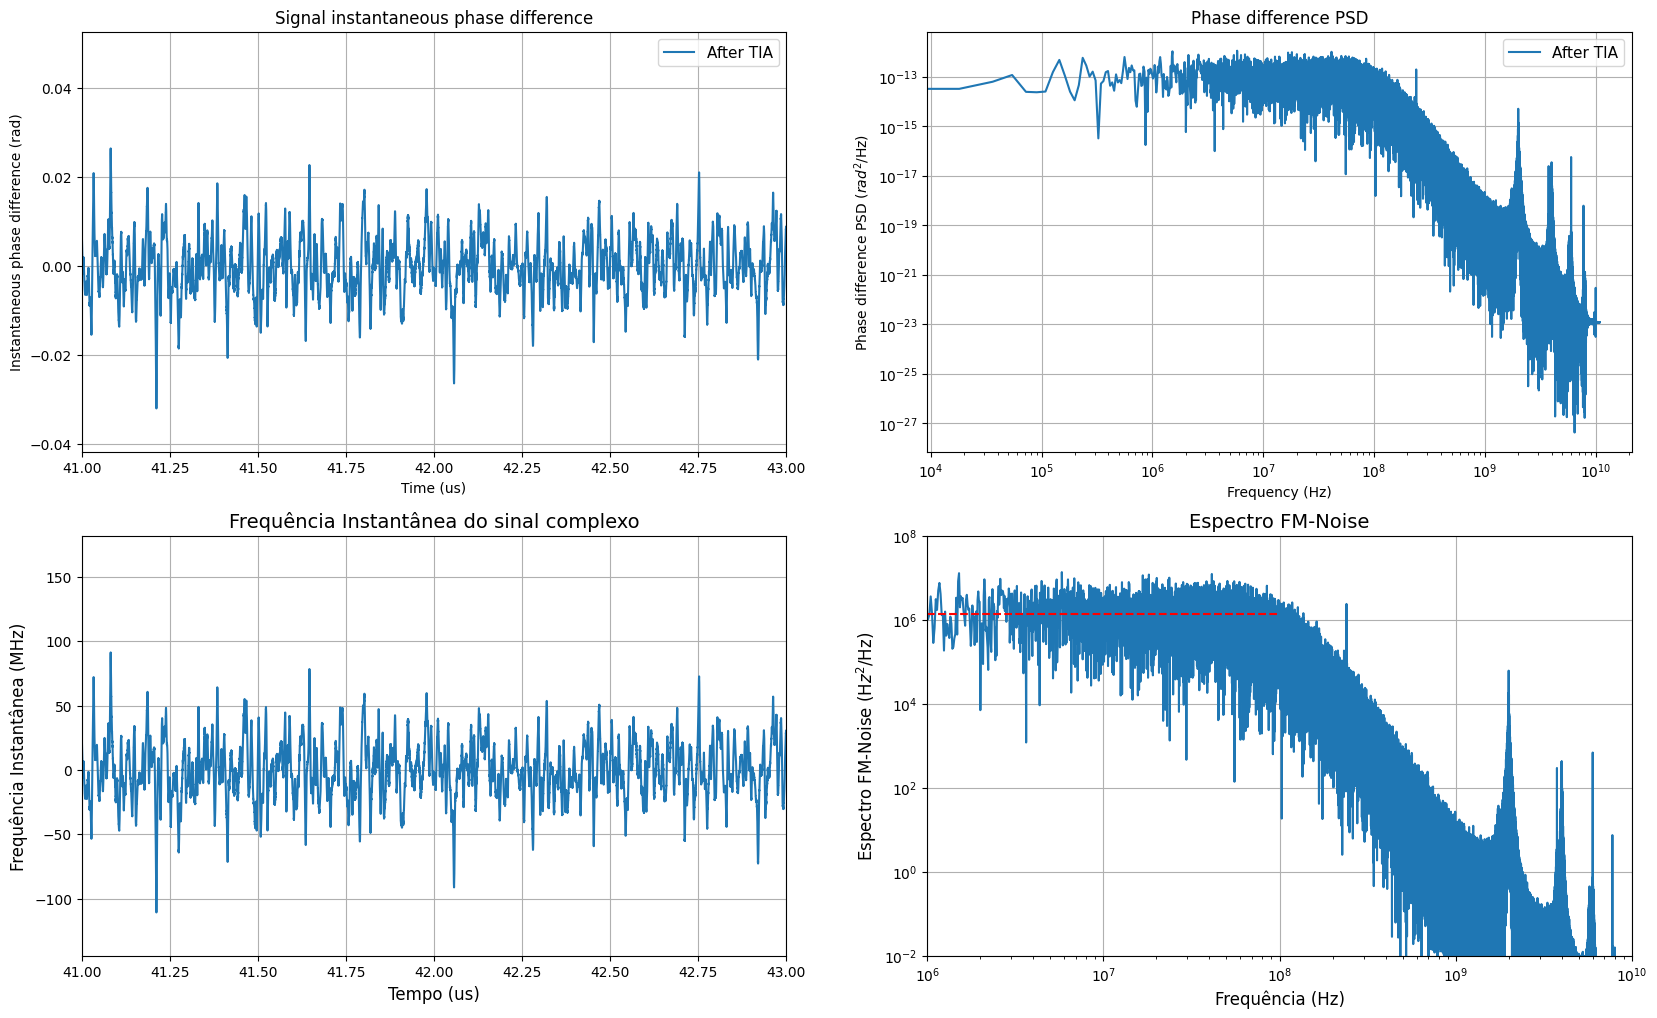

In [169]:
CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
# CplxSig = I_Sig + 1j*Q_Sig
instPhaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),1,cval=0)     # Instantaneous phase difference
instFreq = instPhaseDiff / (2*np.pi*Ts)                                                         # Instantaneous frequency

print(f'Fs = {(1/Ts)*1e-9} GSamples/s')

fig, ax = plt.subplots(2,2)
fig.set_figheight(12)
fig.set_figwidth(20)

StTime = np.min(timeArray*1e6) # Starting time post delay

instPhaseDiff = instPhaseDiff[10000:-10000]
# spectrumDPhase, freqDPhase = mlab.magnitude_spectrum(instPhaseDiff, Fs=Fs, window=mlab.window_none,sides='onesided')
# spectrumDPhase = spectrumDPhase*np.conj(spectrumDPhase)

win = np.hamming(len(instPhaseDiff))                       
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
instPhaseDiff_win = instPhaseDiff * win  
spectrumDPhase = np.abs(np.fft.fft(instPhaseDiff_win, norm='forward'))**2 / ENBW 
freqDPhase = np.fft.fftfreq(len(instPhaseDiff), d=1/Fs)

# freqDPhase = np.fft.fftfreq(len(instPhaseDiff), d=1/Fs)
freqDPhase = freqDPhase[:int(len(freqDPhase)/2)]
# spectrumDPhase = len(instPhaseDiff)*np.abs(np.fft.fft(instPhaseDiff,norm='forward'))**2/(Fs)
spectrumDPhase = 2*spectrumDPhase[:int(len(spectrumDPhase)/2)]

ax[0][0].plot(timeArray[10000:-10000]*1e6,instPhaseDiff, label='After TIA')
ax[0][0].set_xlabel('Time (us)')
ax[0][0].set_ylabel('Instantaneous phase difference (rad)')
ax[0][0].set_title(f'Signal instantaneous phase difference')
ax[0][0].set_xlim(41 , 43)
ax[0][0].grid()
ax[0][0].legend(fontsize=11)

ax[0][1].plot(freqDPhase,spectrumDPhase, label='After TIA')
ax[0][1].set_xscale('log')
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel('Frequency (Hz)')
ax[0][1].set_ylabel('Phase difference PSD ($rad^2$/Hz)')
# ax[0][1].set_xlim(1e6 , 1e10)
# ax[0][1].set_ylim(1e1 , 1e13)
ax[0][1].set_title(f'Phase difference PSD')
ax[0][1].grid()
ax[0][1].legend(fontsize=11)

instFreq = instFreq[10000:-10000]
# instFreq = instFreq-np.mean(instFreq)

# win = windows.flattop(len(instFreq),sym=False)  
win = np.hamming(len(instFreq))                        
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2)
instFreq_win = instFreq * win  
spectrum =  np.abs(np.fft.fft(instFreq_win, norm='forward'))**2 / ENBW
freq = np.fft.fftfreq(len(instFreq), d=1/Fs)

print(ENBW / (Fs/len(instFreq)))

# freq = np.fft.fftfreq(len(instFreq), d=1/Fs)
freq = freq[:int(len(freq)/2)]
# spectrum = len(instFreq)*np.abs(np.fft.fft(instFreq,norm='forward'))**2/(Fs)
spectrum = 2*spectrum[:int(len(spectrum)/2)]

ax[1][0].plot(timeArray[10000:-10000]*1e6,instFreq*1e-6)
ax[1][0].set_xlabel('Tempo (us)',fontsize=12)
ax[1][0].set_xlim(41 , 43)
# ax[0].set_xlim(StTime+0.1,StTime+0.3)
# ax[0].set_ylim(-100,100)
ax[1][0].set_ylabel('Frequência Instantânea (MHz)',fontsize=12)
ax[1][0].set_title(f'Frequência Instantânea do sinal complexo',fontsize=14)
ax[1][0].grid()
# ax[1][0].legend(fontsize=11)

convertedSpectrum = spectrumDPhase*freqDPhase**2/(4*np.sin(np.pi*freqDPhase*Ts)**2)

cutLims = [1e6,10e7]
initFreq = int(cutLims[0]/freq[-1]*len(freq))
endFreq = int(cutLims[1]/freq[-1]*len(freq))
Measurefreq = freq[initFreq:endFreq]
Measurespectrum = spectrum[initFreq:endFreq]
print(freq)

initFreqDP = int(cutLims[0]/freqDPhase[-1]*len(freqDPhase))
endFreqDP = int(cutLims[1]/freqDPhase[-1]*len(freqDPhase))
MeasurefreqDP = freqDPhase[initFreqDP:endFreqDP]
MeasurespectrumDP = convertedSpectrum[initFreqDP:endFreqDP]

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz~~~|~~~Linewidth~(with~correction~factor) = %5.6f~MHz' 
             %(np.round(np.pi*np.mean(Measurespectrum)*1e-6,5), np.round(np.pi*np.mean(Measurespectrum)*1e-6/2,5), np.round(4.6*np.pi*np.mean(Measurespectrum)*1e-6/2,5)) ))

ax[1][1].plot(freq,spectrum, label='FM-Noise PSD')
# ax[1][1].plot(freqDPhase,convertedSpectrum,'--',label='FM-Noise PSD from Phase difference PSD')
ax[1][1].hlines(np.mean(Measurespectrum),xmin=cutLims[0], xmax=cutLims[1], color='red', linestyle='--', label=f'Nível de ruído branco: {np.round(np.mean(Measurespectrum)*1e-6,2)} MHz')
# ax[1][1].hlines(np.mean(MeasurespectrumDP),xmin=cutLims[0], xmax=cutLims[1], color='green', linestyle='--', label=f'{np.round(np.mean(MeasurespectrumDP)*1e-6,2)} MHz (from phase difference PSD)')
ax[1][1].set_xscale('log')
ax[1][1].set_yscale('log')
ax[1][1].set_xlabel('Frequência (Hz)',fontsize=12)
ax[1][1].set_ylabel('Espectro FM-Noise (H$z^2$/Hz)',fontsize=12)
ax[1][1].set_xlim(1e6 , 1e10)
ax[1][1].set_ylim(1e-2 , 1e8)
ax[1][1].set_title(f'Espectro FM-Noise',fontsize=14)
ax[1][1].grid()
# ax[1][1].legend(fontsize=11)

print(np.mean(Measurespectrum)*1e-6)

print(f'New Factor to correcion : {9.925110*1e6/(np.round(np.pi*np.mean(Measurespectrum)/2,5))}')

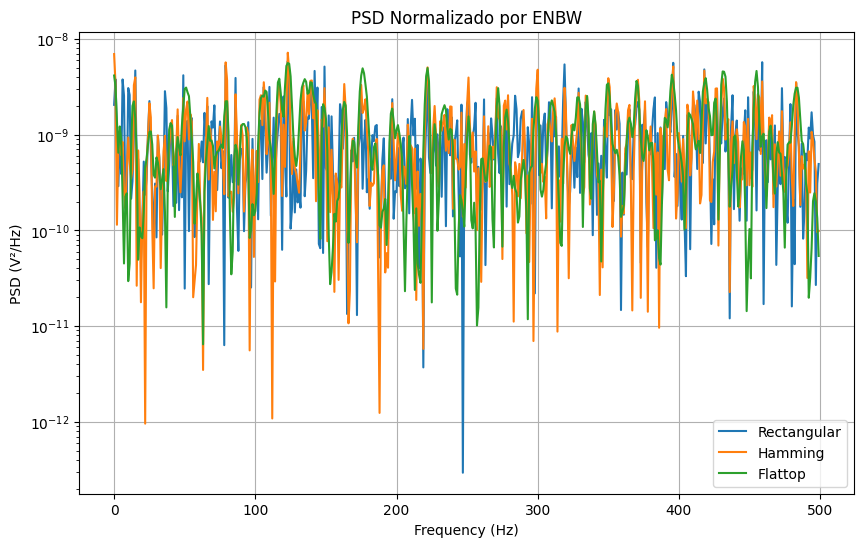

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows

# Parâmetros
Fs = 1e3  # Frequência de amostragem (Hz)
T = 1.0   # Duração do sinal (s)
N = int(Fs * T)  # Número de pontos
np.random.seed(0)  # Reprodutibilidade

# Geração de ruído branco unitário
noise = np.random.randn(N)

# Função auxiliar: cálculo da ENBW
def calculate_enbw(window, Fs):
    S1 = np.sum(window)
    S2 = np.sum(window**2)
    enbw = Fs * (S2 / S1**2)
    return enbw

# Função auxiliar: calcular e normalizar espectro
def compute_psd(signal, window, Fs):
    sig_win = signal * window
    spectrum = np.fft.fft(sig_win, norm='forward')
    S1 = np.sum(window)
    power_spec = (np.abs(spectrum)**2) / (S1**2)
    enbw = calculate_enbw(window, Fs)
    psd = power_spec / enbw
    freq = np.fft.fftfreq(N, 1/Fs)
    return freq[:N//2], psd[:N//2]

# Lista de janelas para testar
windows_list = {
    "Rectangular": np.ones(N),
    "Hamming": windows.hamming(N, sym=False),
    "Flattop": windows.flattop(N, sym=False)
}

plt.figure(figsize=(10,6))
for name, win in windows_list.items():
    freq, psd = compute_psd(noise, win, Fs)
    plt.semilogy(freq, psd, label=name)

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V²/Hz)')
plt.title('PSD Normalizado por ENBW')
plt.legend()
plt.grid(True)
# plt.xlim(0, Fs/2)
# plt.ylim(1e-4, 1e0)
plt.show()


In [129]:
win = np.hamming(len(instFreq))      
print(len(instFreq)/np.sum(win))

1.8518531597360657


In [124]:
RectCorrect = 1.4
HammingCorrect = 4.826879627147525
FlattopCorrect = 30.456407002780825

print(f'Rectangular ENBW : {Fs/len(instFreq)}')

win = np.ones(len(instFreq))
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
rmsloss = np.sqrt(np.sum(win**2))/len(instFreq)
print(rmsloss)

# win = windows.flattop(len(instFreq),sym=False)  
win = np.hamming(len(instFreq))      
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
print(f'Hamming Ratio : {ENBW / (Fs/len(instFreq))}')
print(f'Hamming Power Ratio : {np.sum(win**2) / len(instFreq)}')
print(f'Hamming Total Decrease (inverted) : {(ENBW / (Fs/len(instFreq))) / (np.sum(win**2) / len(instFreq))}  | Correction Ratio : {HammingCorrect/RectCorrect}  ')


win =  windows.flattop(len(instFreq),sym=False)      
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
print(f'flattop Ratio : {ENBW / (Fs/len(instFreq))}')
print(f'flattop Power Ratio : {np.sum(win**2) / len(instFreq)}')
print(f'Hamming Total Decrease (inverted) : {(ENBW / (Fs/len(instFreq))) / (np.sum(win**2) / len(instFreq))}  | Correction Ratio : {FlattopCorrect/RectCorrect}  ')

Rectangular ENBW : 18040.873854827343
0.0009105406506118756
Hamming Ratio : 1.3628266020618311
Hamming Power Ratio : 0.3973996758280481
Hamming Total Decrease (inverted) : 3.4293601252244508  | Correction Ratio : 3.447771162248232  
flattop Ratio : 3.7702464474434287
flattop Power Ratio : 0.17521950295369526
Hamming Total Decrease (inverted) : 21.51727623859189  | Correction Ratio : 21.754576430557734  


In [119]:
1/1.4

0.7142857142857143

In [122]:
RectCorrect = 1.4
HammingCorrect = 4.826879627147525
FlattopCorrect = 30.456407002780825

print(f'Rectangular ENBW : {Fs/len(instFreq)}')

win = np.ones(len(instFreq))
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
rmsloss = np.sqrt(np.sum(win**2))/len(instFreq)
print(ENBW/(Fs/len(instFreq)) /rmsloss)

# win = windows.flattop(len(instFreq),sym=False)  
win = np.hamming(len(instFreq))      
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
print(f'Hamming Ratio : {ENBW / (Fs/len(instFreq))}')
print(f'Hamming Power Ratio : {np.sum(win**2) / len(instFreq)}')
print(f'Hamming Total Decrease (inverted) : {(ENBW / (Fs/len(instFreq))) / (np.sum(win**2) / len(instFreq))}  | Correction Ratio : {HammingCorrect/RectCorrect}  ')


win =  windows.flattop(len(instFreq),sym=False)      
ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
print(f'flattop Ratio : {ENBW / (Fs/len(instFreq))}')
print(f'flattop Power Ratio : {np.sum(win**2) / len(instFreq)}')
print(f'Hamming Total Decrease (inverted) : {(ENBW / (Fs/len(instFreq))) / (np.sum(win**2) / len(instFreq))}  | Correction Ratio : {FlattopCorrect/RectCorrect}  ')

Rectangular ENBW : 18040.873854827343
1098.2486057355138
Hamming Ratio : 1.3628266020618311
Hamming Power Ratio : 0.3973996758280481
Hamming Total Decrease (inverted) : 3.4293601252244508  | Correction Ratio : 3.447771162248232  
flattop Ratio : 3.7702464474434287
flattop Power Ratio : 0.17521950295369526
Hamming Total Decrease (inverted) : 21.51727623859189  | Correction Ratio : 21.754576430557734  


## Phase-Error Variance

<IPython.core.display.Math object>

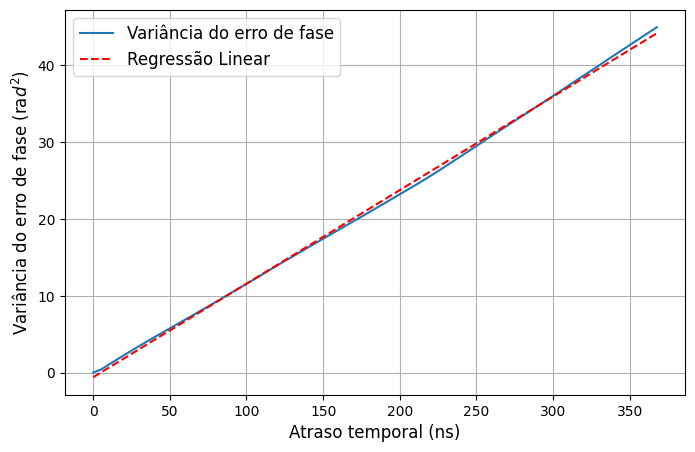

In [98]:
ShiftArray = np.linspace(0,8000,75)

CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig
varianceArray = np.zeros(len(ShiftArray))

for i in range(len(ShiftArray)):
    phaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),ShiftArray[i],cval=0)  # Instantaneous frequency
    varianceArray[i] = np.mean(phaseDiff[200+int(ShiftArray[i]):]**2)

polyArray = np.polyfit(ShiftArray[:1000]*Ts,varianceArray[:1000],1)

plt.figure(figsize=(8,5))
plt.plot(ShiftArray*Ts*1e9,varianceArray,label='Variância do erro de fase')
plt.plot(ShiftArray*Ts*1e9,polyArray[0]*ShiftArray*Ts+polyArray[1],'--',color='red',label='Regressão Linear')
plt.ylabel('Variância do erro de fase (ra$d^2$)',fontsize=12)
plt.xlabel('Atraso temporal (ns)',fontsize=12)
plt.grid()
plt.legend(fontsize=12)

display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(polyArray[0]*1e-6/(2*np.pi) , (polyArray[0]*1e-6/(2*np.pi))/2 )))

According to the reference *Characterization of Semiconductor-Laser Phase Noise with Digital Coherent Receivers* by Kazuro KIKUCHI, getting the 3-db bandwidth $\delta f$, the other methods can be calculated:
$$\text{FM noise white spectral density: }  \delta f / \pi$$
$$\text{Phase error variance: }  \sigma(\tau)^2 = 2 \pi \delta f \tau$$

In [77]:
display(Math('FM~noise~white~spectral~density = %5.6f ~MHz~(DFB)~~~|~~~ Phase~error~variance~slope = %5.6f~(DFB)' %(delF/(2*np.pi),2*np.pi*delF/2)))

<IPython.core.display.Math object>

# Model Validity Sweep

In [177]:
lwArray = np.linspace(1e6,30e6,30)
# lwArray = np.linspace(3e6,30e6,21)
print(f'Linewidths: {lwArray*1e-6} MHz')

Linewidths: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.] MHz


In [182]:
lwArray = np.linspace(1e6,30e6,30)
print(f'Linewidths: {lwArray*1e-6} MHz')

PSDArray = np.zeros(len(lwArray))
PSDFitArray = np.zeros(len(lwArray))
FMArray = np.zeros(len(lwArray))
PNoiseArray = np.zeros(len(lwArray))

LorentzLWArray = np.linspace(1e6,70e6,3000)
print(f'Lorentz Fit resolution: {(LorentzLWArray[1] - LorentzLWArray[0])*1e-6} MHz')

progress_bar = tqdm(total=len(lwArray), desc="Sweeping through linewidths... ")

for k in range(len(lwArray)):

    SpS = 64*4    # Samples per Symbol
    Rs = 170e6  # Symbol rate (for OOK case Rs = Rb)

    Tsymb = 1/Rs       # Symbol period in seconds
    Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
    Ts = 1/Fs          # Sampling period

    bitsTx = np.ones(2**14)

    lmbd = 1540e-9         # Central Wavelength [m]
    KConst = 0.5           # Coupling Constant (0 to 1)
    KPhase = (1/2)*np.pi   # Coupling Phase Delay between arms (rad)

    SMFLen = 12              # Single Mode Fiber Length (km)
    SMFAtt = 0.22            # Single Mode Fiber Attenuation (dB/km)
    SMFGamma = 1.2           # Single Mode Fiber Nonlinear parameter (1/(W*km))
    SMFDisp = 16             # Single Mode Fiber Chromatic Dispersion parameter (ps/nm/km)
    tau = SMFLen/(c*1e-3)    # Fiber Delay

    mFreq = 2e9     # Frequency of the electrical modulating signal (Hz)
    mPhase = 0      # Phase of the electrical modulating signal (Radians)
    R = 1           # Photodiode Responsivity

    tArray = np.arange(0,SpS*len(bitsTx))*Ts

    laser_parameters = parameters()
    laser_parameters.P = 10 # laser power [dBm] 
    laser_parameters.lw = lwArray[k] # laser linewidth [Hz] 
    laser_parameters.RIN_var = 1e-20 # variance of the RIN noise 
    laser_parameters.Fs = Fs # sampling rate [samples/s]
    laser_parameters.Ns = SpS*bitsTx.size # number of signal samples

    OptSig = basicLaserModel(laser_parameters)

    LinearFiber_parameters = parameters()
    LinearFiber_parameters.L = SMFLen           # [km] total fiber length
    LinearFiber_parameters.alpha = SMFAtt       # [dB/km] fiber attenuation parameter 
    LinearFiber_parameters.D = SMFDisp          # [ps/nm/km] chromatic dispersion parameter
    LinearFiber_parameters.Fc = c/lmbd          # [Hz] carrier frequency
    LinearFiber_parameters.Fs = Fs              # [Hz] sampling frequency 

    bIdx = 2          # Modulation index of the electrical modulating signal
    vPi = 5               # Modulator vPi [Volts]

    TIACutFreq = 10e9  # TIA Filter cuttoff frequency in Hz   
    TIAorder = 1  # TIA Filter order      

    DemodCutFreq = 0.1e9  # Demodulation Filter cuttoff frequency in Hz     
    Demodorder = 3  # Demodulation Filter order

    tau = SMFLen/(c*1e-3)    # Fiber Delay
    shiftValue = int(len(tArray)*tau/tArray[-1])

    EUpper = linearFiberChannel(OptSig*np.sqrt(KConst),LinearFiber_parameters) # Upper arm Optical signal post fiber 
    EUpper = shift(EUpper,shiftValue,cval=EUpper[0]) # Applying delay
    EUpper = EUpper[shiftValue:]

    carrier = OptSig*np.sqrt(1-KConst)*np.exp(KPhase*1j)  # Bottom arm Optical signal
    elecSig = vPi*bIdx*np.sin(2*np.pi*mFreq*tArray+mPhase) # Electrical signal for pm modulation
    EBottom = pm(carrier,elecSig,vPi)  # PM modulation
    EBottom = EBottom[shiftValue:]

    timeArray = tArray[shiftValue:]

    Epd = KConst*EUpper + (1-KConst)*np.exp(1j*KPhase)*EBottom   # E-Field Incident on Photodiode
    Eosa = (1-KConst)*np.exp(1j*KPhase)*EUpper + KConst*EBottom  # E-Field Incident on OSA

    IPd = 2*R*np.abs(Epd)**2    # Current Post-Photodiode

    # TIA Filter ---------------------------------------------------------

    w_norm = TIACutFreq / (Fs/2)
    b,a = signal.bessel(N=TIAorder, Wn=w_norm, btype='low', norm='phase')
    w, h = signal.freqz(b, a, worN=1024, fs=Fs)
    FilteredIPd = signal.lfilter(b, a, IPd)

    Q_Sig = FilteredIPd*np.sin(2*np.pi*mFreq*timeArray+mPhase)
    I_Sig = -FilteredIPd*np.cos(2*(2*np.pi*mFreq*timeArray+mPhase))

    # Demodulation Filtering ----------------------------------------------      

    w_norm = DemodCutFreq / (Fs/2)
    b,a = signal.bessel(N=Demodorder, Wn=w_norm, btype='low', norm='phase')
    w, h = signal.freqz(b, a, worN=1024, fs=Fs)
    FilteredQ_Sig = signal.lfilter(b, a, Q_Sig)
    FilteredI_Sig = signal.lfilter(b, a, I_Sig)



    # PSD Method ----------------------------------------------------------

    centerFreq = 2e9
    cutLims = [1.45e9,2.55e9]

    win = np.hamming(len(FilteredIPd))                       
    ENBW = Fs * np.sum(win**2) / (np.sum(win)**2) 
    FilteredIPd_win = FilteredIPd * win  
    spectrum = np.abs(np.fft.fft(FilteredIPd_win, norm='forward'))**2 / ENBW 
    freq = np.fft.fftfreq(len(FilteredIPd), d=1/Fs)

    spectrum = spectrum[:int(len(freq)/2)]
    freq = freq[:int(len(freq)/2)]
    initFreq = int((cutLims[0]-freq[0])/(freq[-1]-freq[0])*len(freq))
    endFreq = int((cutLims[1]-freq[0])/(freq[-1]-freq[0])*len(freq))

    freq = freq[initFreq:endFreq]
    spectrum =  10*np.log10(2*spectrum[initFreq:endFreq])

    # Filter spectrum
    Ntaps = 260
    b = signal.firwin(numtaps = Ntaps, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[Ntaps:-Ntaps]  

    BestrightMark = 0
    BestleftMark = 0

    freqCutted = freq[Ntaps:-Ntaps].copy()

    for i in range(len(FilteredSpec)-1):
        if FilteredSpec[i+1] >= np.max(FilteredSpec)-3 and FilteredSpec[i] < np.max(FilteredSpec)-3:
            # print(f'leftMark between {np.round(freqCutted[i]*1e-6,2)} and {np.round(freqCutted[i+1]*1e-6,2)} MHz')
            leftMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(leftMark-centerFreq) < np.abs(BestleftMark-centerFreq) and leftMark < centerFreq):
                BestleftMark = leftMark
                # print(f'BestleftMark: {BestleftMark*1e-6} MHz')
        elif FilteredSpec[i+1] < np.max(FilteredSpec)-3 and FilteredSpec[i] >= np.max(FilteredSpec)-3:
            # print(f'rightMark between {np.round(freqCutted[i]*1e-6,2)} and {np.round(freqCutted[i+1]*1e-6,2)} MHz')
            rightMark = (np.max(FilteredSpec)-3-FilteredSpec[i])/(FilteredSpec[i+1]-FilteredSpec[i]) * (freqCutted[i+1]-freqCutted[i]) + freqCutted[i]
            if (np.abs(rightMark-centerFreq) < np.abs(BestrightMark-centerFreq) and rightMark > centerFreq):
                BestrightMark = rightMark
                # print(f'BestrightMark: {BestrightMark*1e-6} MHz')

    delF = BestrightMark*1e-6-BestleftMark*1e-6
    PSDArray[k] = (BestrightMark-BestleftMark)/2
    # display(Math('PSD~Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(delF, delF/2 )))



    NtapsIt = 185
    b = signal.firwin(numtaps = NtapsIt, cutoff = 1e-5, window='hamming')
    FilteredSpec = firFilter(b, spectrum)[NtapsIt:-NtapsIt] 

    corArray = np.zeros(len(LorentzLWArray)) 

    for i in range(len(LorentzLWArray)):
        delVit = LorentzLWArray[i]
        LorentzS = 10*np.log10(1/(2*np.pi) * delVit/((freq - centerFreq)**2 + (delVit/2)**2))
        LorentzS = LorentzS + (np.max(FilteredSpec)-np.max(LorentzS))
        corArray[i] = np.sum(np.abs(LorentzS[NtapsIt:-NtapsIt] - FilteredSpec)**2)

    PSDFitArray[k] = LorentzLWArray[np.argmin(corArray)] / 2



    # FM noise Method ----------------------------------------------------------

    CplxSig = FilteredI_Sig + 1j*FilteredQ_Sig

    instPhaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),1,cval=0)     # Instantaneous phase difference
    instFreq = instPhaseDiff / (2*np.pi*Ts)                                                         # Instantaneous frequency

    instFreq = instFreq[10000:-10000]
    instFreq = instFreq-np.mean(instFreq)

    win = np.hamming(len(instFreq))                        
    ENBW = Fs * np.sum(win**2) / (np.sum(win)**2)
    instFreq_win = instFreq * win  
    spectrum =  np.abs(np.fft.fft(instFreq_win, norm='forward'))**2 / ENBW
    freq = np.fft.fftfreq(len(instFreq), d=1/Fs)

    # freq = np.fft.fftfreq(len(instFreq), d=1/Fs)
    freq = freq[:int(len(freq)/2)]
    # spectrum = len(instFreq)*np.abs(np.fft.fft(instFreq,norm='forward'))**2/(Fs)
    spectrum = 2*spectrum[:int(len(spectrum)/2)]

    cutLims = [1e6,1e8]
    initFreq = int(cutLims[0]/freq[-1]*len(freq))
    endFreq = int(cutLims[1]/freq[-1]*len(freq))
    Measurefreq = freq[initFreq:endFreq]
    Measurespectrum = spectrum[initFreq:endFreq]

    FMArray[k] = np.pi*np.mean(Measurespectrum)/2
    # display(Math('FM~noise~Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(np.round(np.pi*np.mean(Measurespectrum)*1e-6,5), np.round(np.pi*np.mean(Measurespectrum)*1e-6/2,5))))



    # Phase-Error Vaiance Method ----------------------------------------------------------

    ShiftArray = np.linspace(0,8000,75)
    varianceArray = np.zeros(len(ShiftArray))

    for i in range(len(ShiftArray)):
        phaseDiff = np.unwrap(np.angle(CplxSig)) - shift(np.unwrap(np.angle(CplxSig)),ShiftArray[i],cval=0)  # Instantaneous frequency
        varianceArray[i] = np.mean(phaseDiff[200+int(ShiftArray[i]):]**2)

    polyArray = np.polyfit(ShiftArray[:1000]*Ts,varianceArray[:1000],1)

    PNoiseArray[k] = (polyArray[0]/(2*np.pi)) / 2
    # display(Math('Measured~Linewidth = %5.6f~MHz~~~|~~~DFB~Linewidth = %5.6f~MHz' %(polyArray[0]*1e-6/(2*np.pi) , (polyArray[0]*1e-6/(2*np.pi))/2 )))

    progress_bar.update(1)  # Updates progress bar

Linewidths: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.] MHz
Lorentz Fit resolution: 0.023007669223074335 MHz


Sweeping through linewidths... :   0%|          | 0/30 [00:00<?, ?it/s]

In [200]:
correctFac = np.round(np.mean(lwArray/FMArray),3)
print(f'Correction Factor: {correctFac}')

Correction Factor: 4.802


In [203]:
correctFac = 4.8

Mean Error from PSD FWHM: 18.561101922566696 %
Mean Error from PSD Lorentzian Fit: 6.302133574242252 %
Mean Error from FM White Noise (with correction factor): 1.828375247417679 %
Mean Error from Phase Noise Variance: 6.047781239683145 %


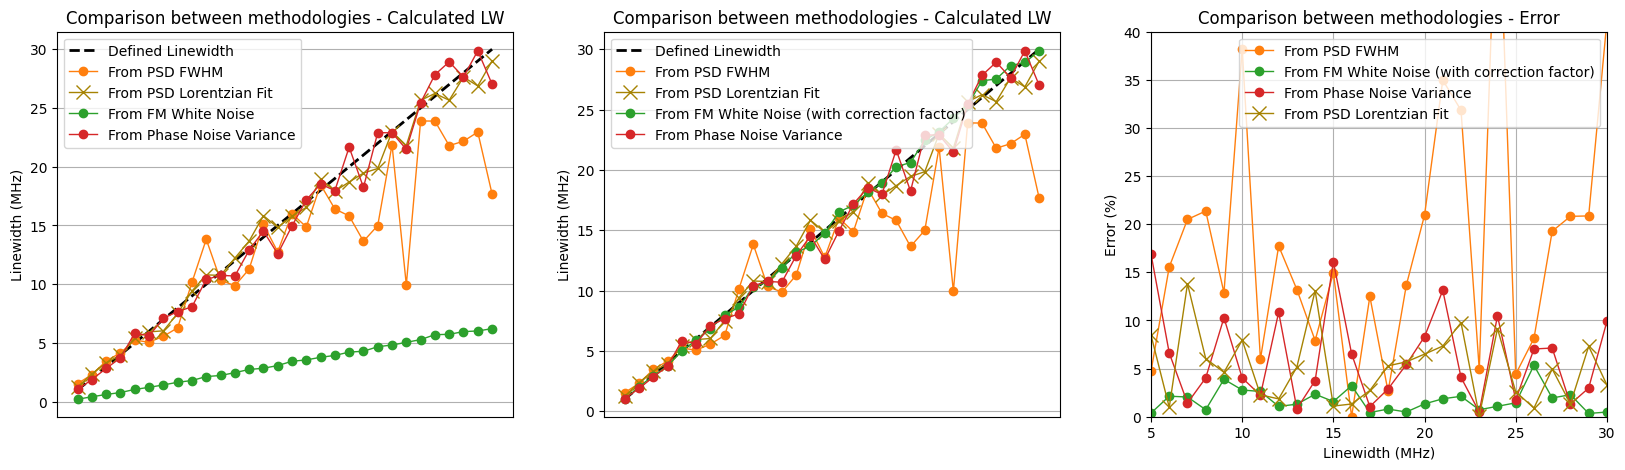

In [204]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(20)

ax[0].plot(lwArray*1e-6,color='black',linestyle='--',linewidth=2,label='Defined Linewidth')
ax[0].plot(PSDArray*1e-6,'-o',color='C1',linewidth=1,label='From PSD FWHM')
ax[0].plot(PSDFitArray*1e-6,'-x',color='#a68303',linewidth=1,label='From PSD Lorentzian Fit', markersize=10)
ax[0].plot(FMArray*1e-6,'-o',color='C2',linewidth=1,label='From FM White Noise')
ax[0].plot(PNoiseArray*1e-6,'-o',color='C3',linewidth=1,label='From Phase Noise Variance')
ax[0].set_ylabel('Linewidth (MHz)',fontsize=10)
ax[0].set_xticks([])
ax[0].set_title('Comparison between methodologies - Calculated LW',fontsize=12)
ax[0].legend(fontsize=10)
ax[0].grid()

ax[1].plot(lwArray*1e-6,color='black',linestyle='--',linewidth=2,label='Defined Linewidth')
ax[1].plot(PSDArray*1e-6,'-o',color='C1',linewidth=1,label='From PSD FWHM')
ax[1].plot(PSDFitArray*1e-6,'-x',color='#a68303',linewidth=1,label='From PSD Lorentzian Fit', markersize=10)
ax[1].plot(correctFac*FMArray*1e-6,'-o',color='C2',linewidth=1,label='From FM White Noise (with correction factor)')
ax[1].plot(PNoiseArray*1e-6,'-o',color='C3',linewidth=1,label='From Phase Noise Variance')
ax[1].set_ylabel('Linewidth (MHz)',fontsize=10)
ax[1].set_xticks([])
ax[1].set_title('Comparison between methodologies - Calculated LW',fontsize=12)
ax[1].legend(fontsize=10)
ax[1].grid()

ax[2].plot(lwArray*1e-6,100*np.abs(PSDArray-lwArray)/lwArray,'-o',color='C1',linewidth=1,label='From PSD FWHM')
ax[2].plot(lwArray*1e-6,100*np.abs(correctFac*FMArray-lwArray)/lwArray,'-o',color='C2',linewidth=1,label='From FM White Noise (with correction factor)')
ax[2].plot(lwArray*1e-6,100*np.abs(PNoiseArray-lwArray)/lwArray,'-o',color='C3',linewidth=1,label='From Phase Noise Variance')
ax[2].plot(lwArray*1e-6,100*np.abs(PSDFitArray-lwArray)/lwArray,'-x',color='#a68303',linewidth=1,label='From PSD Lorentzian Fit', markersize=10)
ax[2].set_xlim(5,30)
ax[2].set_ylim(0,40)
ax[2].set_ylabel('Error (%)',fontsize=10)
ax[2].set_xlabel('Linewidth (MHz)')
ax[2].set_title('Comparison between methodologies - Error',fontsize=12)
ax[2].legend(fontsize=10)
ax[2].grid()

print(f'Mean Error from PSD FWHM: {np.mean(100*np.abs(PSDArray-lwArray)/lwArray)} %')
print(f'Mean Error from PSD Lorentzian Fit: {np.mean(100*np.abs(PSDFitArray-lwArray)/lwArray)} %')
print(f'Mean Error from FM White Noise (with correction factor): {np.mean(100*np.abs(correctFac*FMArray-lwArray)/lwArray)} %')
print(f'Mean Error from Phase Noise Variance: {np.mean(100*np.abs(PNoiseArray-lwArray)/lwArray)} %')

datapath = '../../Media/Delayed_Self-Heterodyne'
file_count = sum(len(files) for _, _, files in os.walk(datapath))
plt.savefig(datapath+"/"+"Methodologies_Comparison_Lorentzian" + ".png", transparent=False, facecolor="white", bbox_inches="tight")

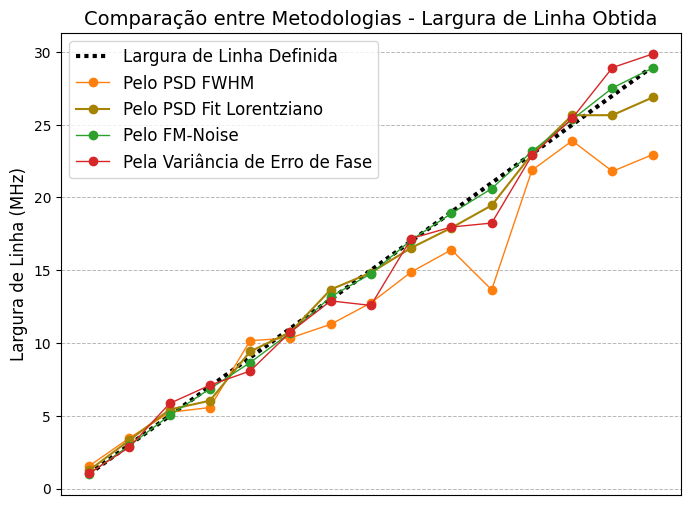

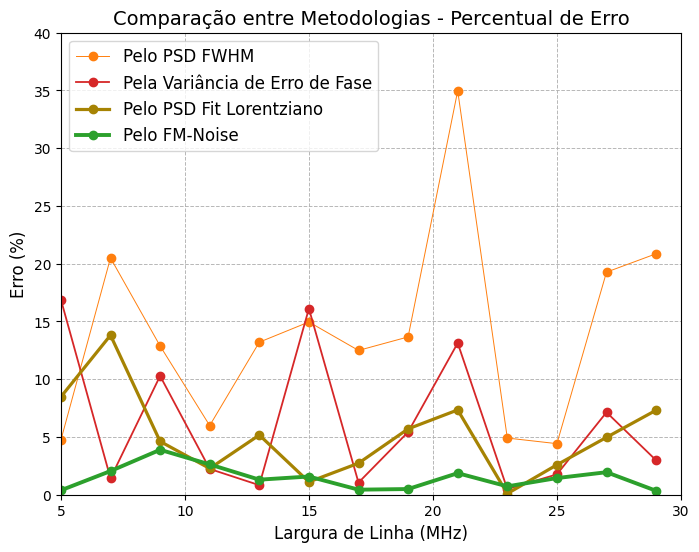

In [199]:
plt.figure(figsize=(8,6))
plt.plot(lwArray[::2]*1e-6, color='black', linestyle=(0, (1, 1)), linewidth=3, markersize=5, label='Largura de Linha Definida')
plt.plot(PSDArray[::2]*1e-6,'-o',color='C1',linewidth=1,label='Pelo PSD FWHM')
plt.plot(PSDFitArray[::2]*1e-6,'-o',color='#a68303',linewidth=1.5,label='Pelo PSD Fit Lorentziano')
plt.plot(correctFac*FMArray[::2]*1e-6,'-o',color='C2',linewidth=1,label='Pelo FM-Noise')
# plt.plot(FMArray[::2]*1e-6,'-o',color='C4',linewidth=1,label='Pelo FM-Noise')
plt.plot(PNoiseArray[::2]*1e-6,'-o',color='C3',linewidth=1,label='Pela Variância de Erro de Fase')
plt.ylabel('Largura de Linha (MHz)',fontsize=12)
plt.xticks([])
plt.title('Comparação entre Metodologias - Largura de Linha Obtida',fontsize=14)
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.9)

plt.savefig("MethodsLW.pdf", format="pdf")

plt.figure(figsize=(8,6))
plt.plot(lwArray[::2]*1e-6,100*np.abs(PSDArray-lwArray)[::2]/lwArray[::2],'-o',color='C1',linewidth=0.7,label='Pelo PSD FWHM')
plt.plot(lwArray[::2]*1e-6,100*np.abs(PNoiseArray-lwArray)[::2]/lwArray[::2],'-o',color='C3',linewidth=1.3,label='Pela Variância de Erro de Fase')
plt.plot(lwArray[::2]*1e-6,100*np.abs(PSDFitArray-lwArray)[::2]/lwArray[::2],'-o',color='#a68303',linewidth=2.3,label='Pelo PSD Fit Lorentziano')
plt.plot(lwArray[::2]*1e-6,100*np.abs(correctFac*FMArray-lwArray)[::2]/lwArray[::2],'-o',color='C2',linewidth=2.8,label='Pelo FM-Noise')
plt.xlim(5,30)
plt.ylim(0,40)
plt.ylabel('Erro (%)',fontsize=12)
plt.xlabel('Largura de Linha (MHz)',fontsize=12)
plt.title('Comparação entre Metodologias - Percentual de Erro',fontsize=14)
plt.legend(fontsize=12)
plt.grid(linestyle='--', linewidth=0.7, alpha=0.9)

plt.savefig("MethodsLWError.pdf", format="pdf")